In [990]:
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
dataset_name = "CAVIAR-o" #"IDIAP" #"CAVIAR-o"
dataset_path = 'data/CAVIAR-o.pkl.gz' #'data//IDIAP.pkl' #'data/CAVIAR-o.pkl.gz' #
net_output = 'pan'
model_type = 'cvae'

In [150]:
(xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output)

image_height, image_width, n_channels = xtr.shape[1], xtr.shape[2], xtr.shape[3]

In [436]:
if dataset_name=='CAVIAR-o':
    pretrained_path = 'pretrained_models/CAVIAR-o'

vggbit_cosine_config_path = os.path.join(pretrained_path, 'cosine/model.best.params.yml')
vggbit_cosine_weights_path = os.path.join(pretrained_path, 'cosine/model.best.weights.hdf5')
vggbit_likelihood_config_path = os.path.join(pretrained_path, 'likelihood/model.best.params.yml')
vggbit_likelihood_weights_path =  os.path.join(pretrained_path, 'likelihood/model.best.weights.hdf5')
vmmix_config_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.params.yml')
vmmix_weights_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.weights.hdf5')
cvae_config_path =  os.path.join(pretrained_path, 'cvae/model.trial_0.params.yml')
cvae_weights_path =  os.path.join(pretrained_path, 'cvae/model.trial_0.best.weights.hdf5')

In [629]:
def load_config(net_config_path):
    with open(net_config_path, 'r') as f:
        net_config = yaml.load(f)
    return net_config

vggbit_cosine_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=False,
                                loss_type='cosine',
                                **load_config(vggbit_cosine_config_path))
vggbit_cosine_model.load_weights(vggbit_cosine_weights_path)
_ = vggbit_cosine_model.finetune_kappa(xval, yval_bit, max_kappa=1000)

vggbit_likelihood_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=True,
                                loss_type='vm_likelihood',
                                **load_config(vggbit_likelihood_config_path))
vggbit_likelihood_model.load_weights(vggbit_likelihood_weights_path)

vmmix_model = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            **load_config(vmmix_config_path))

vmmix_model.load_weights(vmmix_weights_path)
    


using cosine loss..
using likelihood loss..


In [991]:
cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

#cvae_model.load_weights(cvae_weights_path)

In [992]:
starting_frame = 0
n_frames = 10
frames = np.arange(starting_frame, starting_frame+n_frames)
n_samples = 10
xvals =  np.arange(0, 2*np.pi, 0.01)

results = eval_all_models(xte[frames], yte_deg[frames], 'test')

pdfs_dict = {}

vggcosine_acc_pdf = vggbit_cosine_model.pdf(xte[frames], xvals)

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[frames], xvals)

vmmix_pdfs, vmmix_acc_pdf = vmmix_model.pdf(xte[frames], xvals)

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[frames], xvals, n_samples=n_samples)

*****EVALUATING ON test*****
evaluating VGGBit (cosine loss)..
MAAD error (test) : 6.280240 pm 4.229848SEM
log-likelihood (test) : -0.078851 pm 0.817739SEM
evaluating VGGBit (likelihood loss)..
MAAD error (test) : 3.314404 pm 0.974526SEM
log-likelihood (test) : 1.077502 pm 0.251830SEM
evaluating VM-Mixture..
MAAD error (test) : 17.015297 pm 16.198239SEM
log-likelihood (test) : 2.097093 pm 1.051655SEM
evaluating CVAE..
MAAD error (test) : 67.386437 pm 14.785218SEM
ELBO (test) : -2.031464 pm 0.097885SEM
Approx Log-Likelihood, importance sampling (test) : -1.758897 pm 0.077119SEM
KL-div (test) : 0.006922 pm0.000646SEM


In [1000]:
def plot_pdf(axis, xvals, pdf, ypred=None, gt_val=None, title=''):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
    axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_ylim([0, 10.0])
    if gt_val is not None:
        axis.axvline(gt_val, color='red', label='gt')
    if ypred is not None:
        axis.axvline(ypred, color='blue', label='pred')
    axis.plot(xvals, pdf)
    axis.legend(loc=1)
    axis.set_title(title)
    return

In [1001]:
def plot_image_results(im, fid, xvals, pdfs_dict, likelihoods_dict, maad_dict, ppreds_dict, ytr_rad):
    
    n_pdfs = len(pdfs_dict)
    
    fig, axs = plt.subplots(1, n_pdfs+1, figsize=(30, 5))
    
    axs[0].imshow(im)
    
    i=1
    
    for pdf_name, pdf in pdfs_dict.items():
        ypred_rad = np.deg2rad(ppreds_dict[pdf_name])
        title = "%s (logL$\\approx$%.2f, AAD=%.2f°)" % (pdf_name, likelihoods_dict[pdf_name], maad_dict[pdf_name])
        plot_pdf(axs[i], xvals, pdf, ypred_rad, ytr_rad, title)
        i+=1
    
    # plot_pdf(axs[1], xvals, acc_pdf, ytr_rad)
    #for sid in range(0, n_components):
        #plot_pdf(axs[2], xvals, samples_pdf[sid], ytr_rad)
    
    fig.suptitle("Frame ID : %d" % fid)
    plt.show()
    
    return

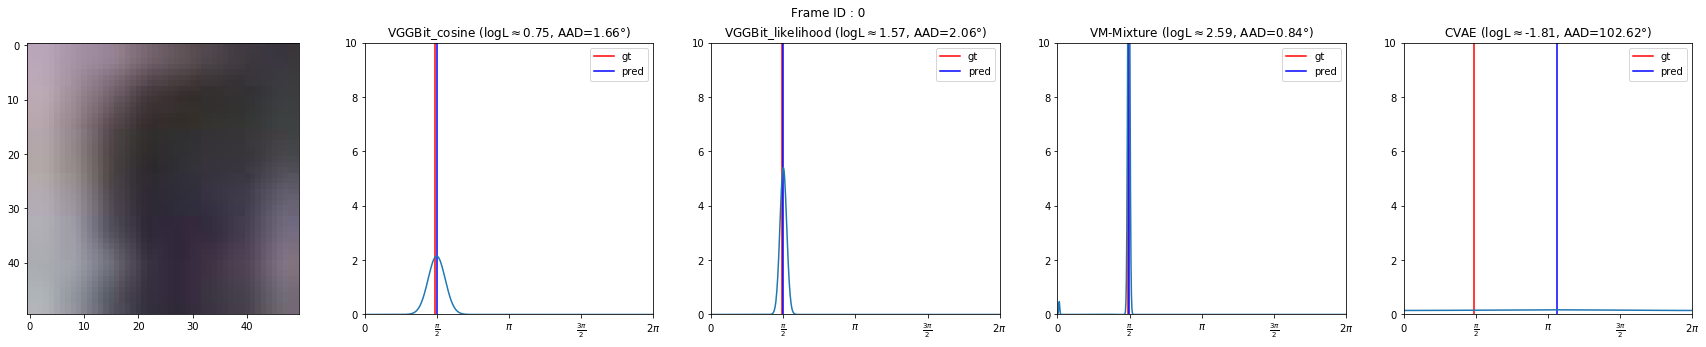

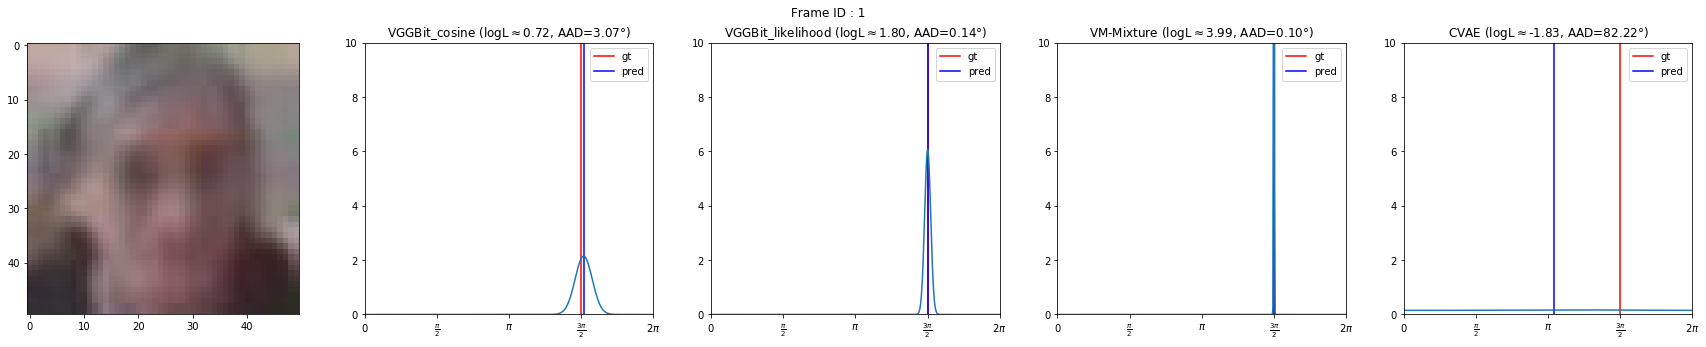

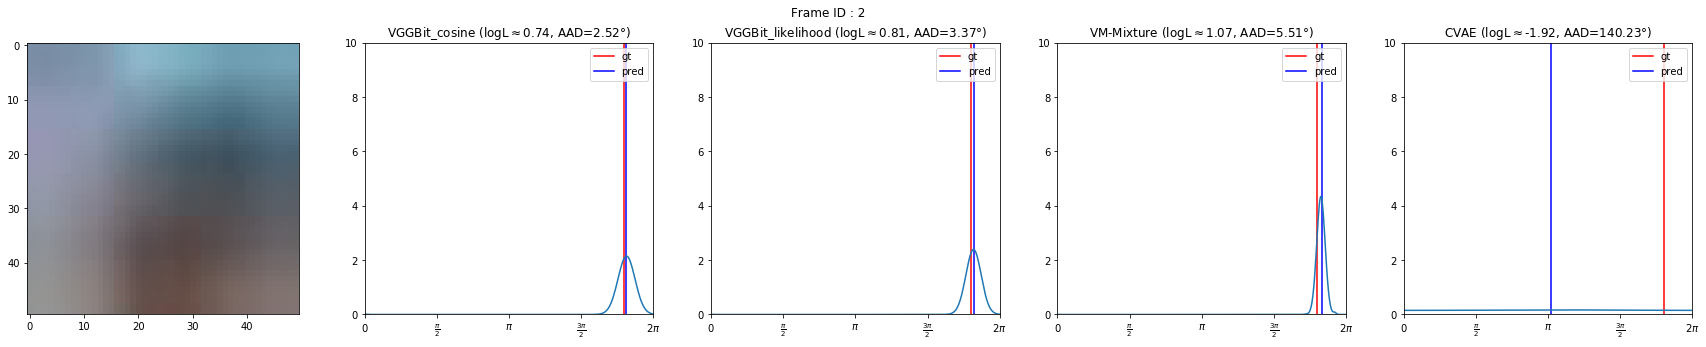

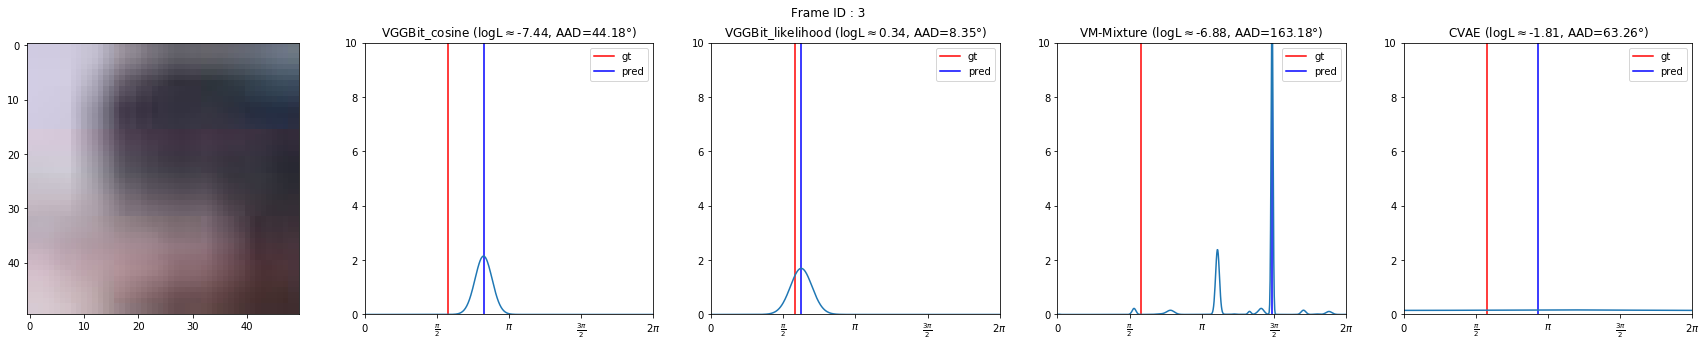

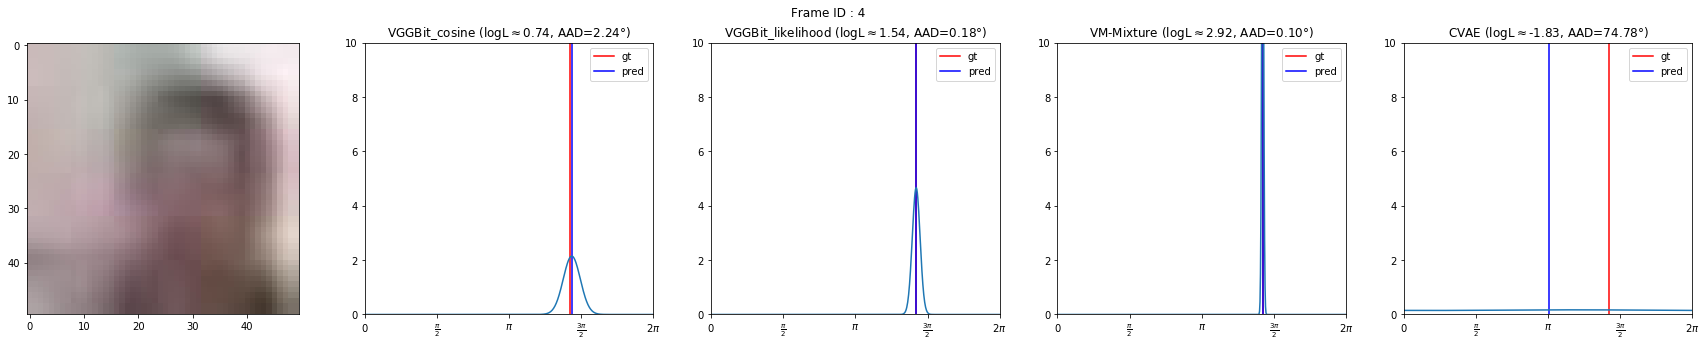

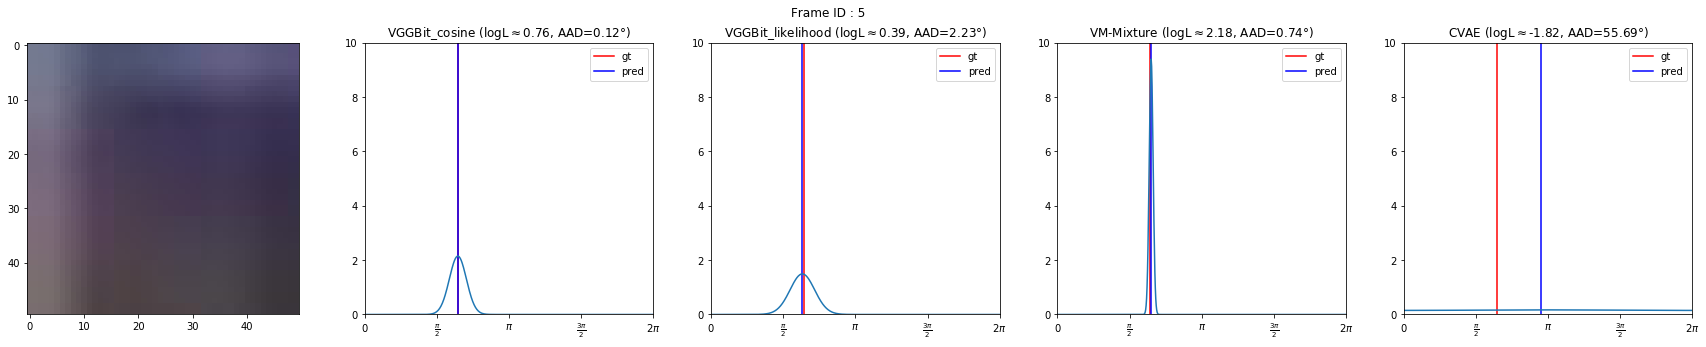

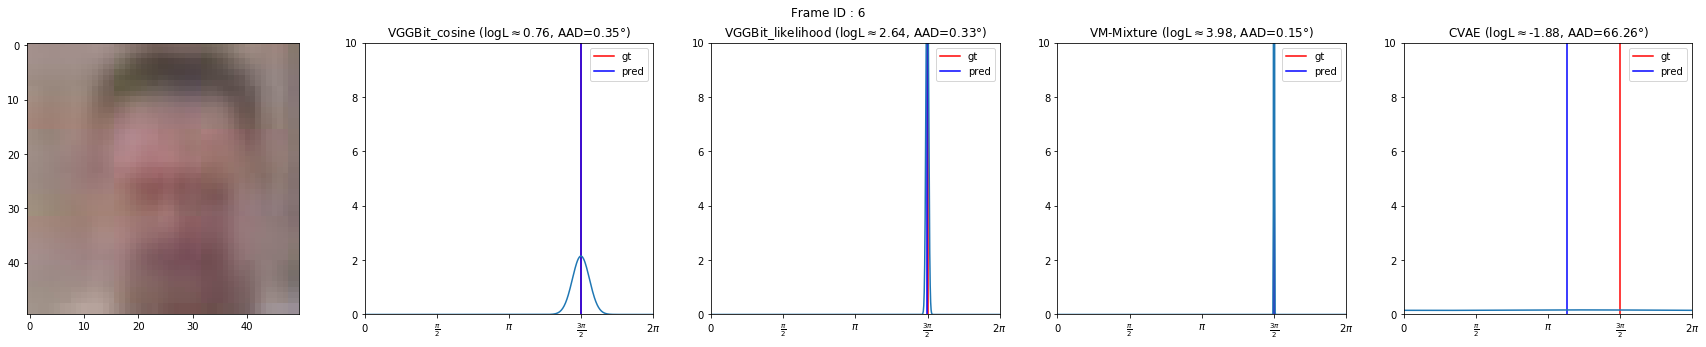

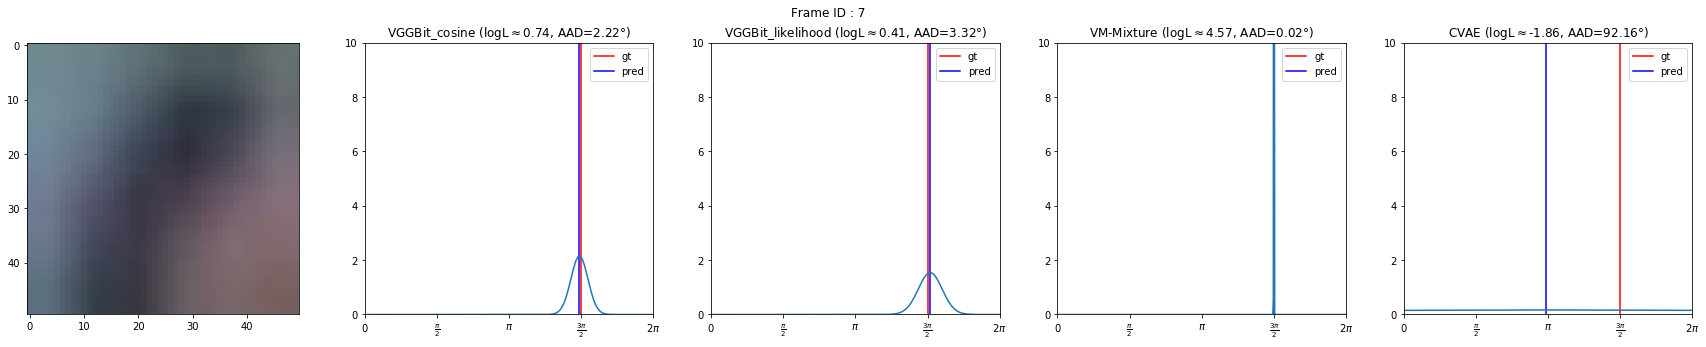

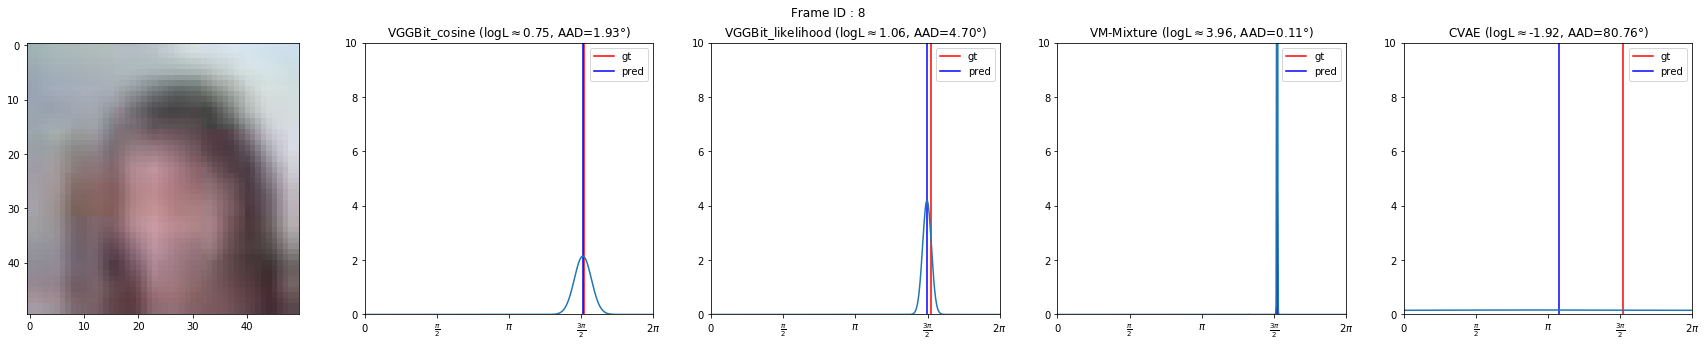

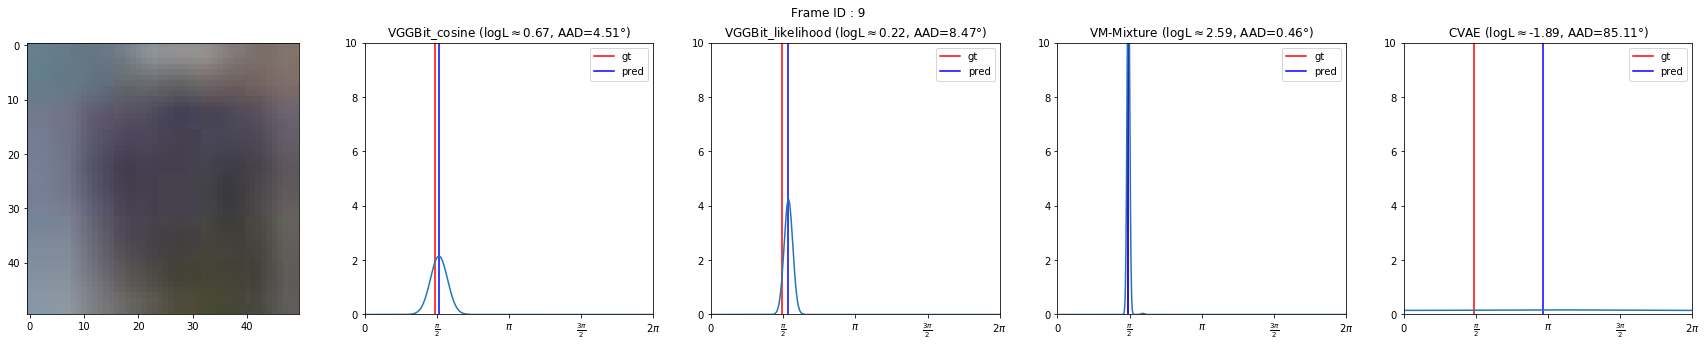

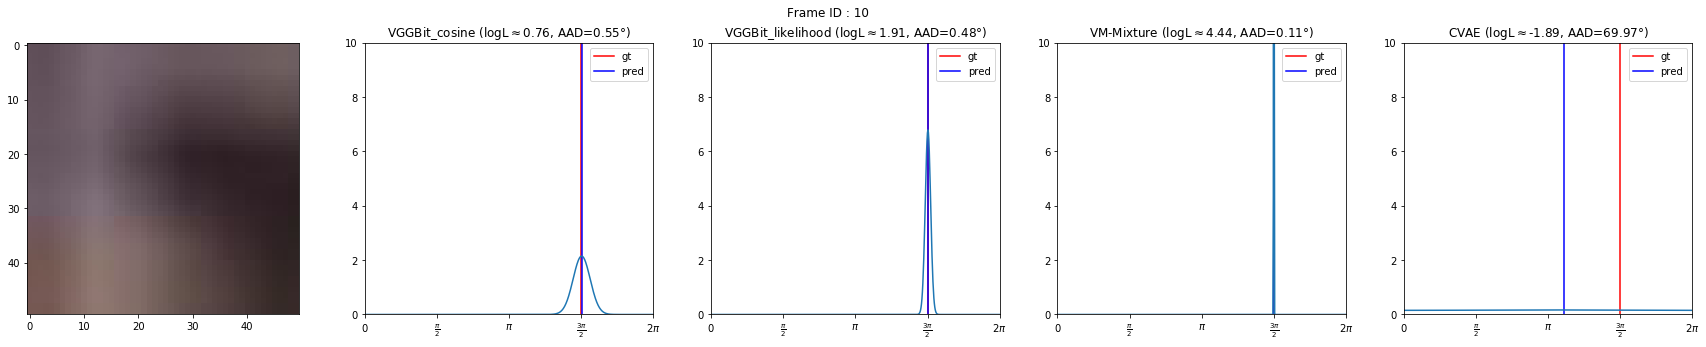

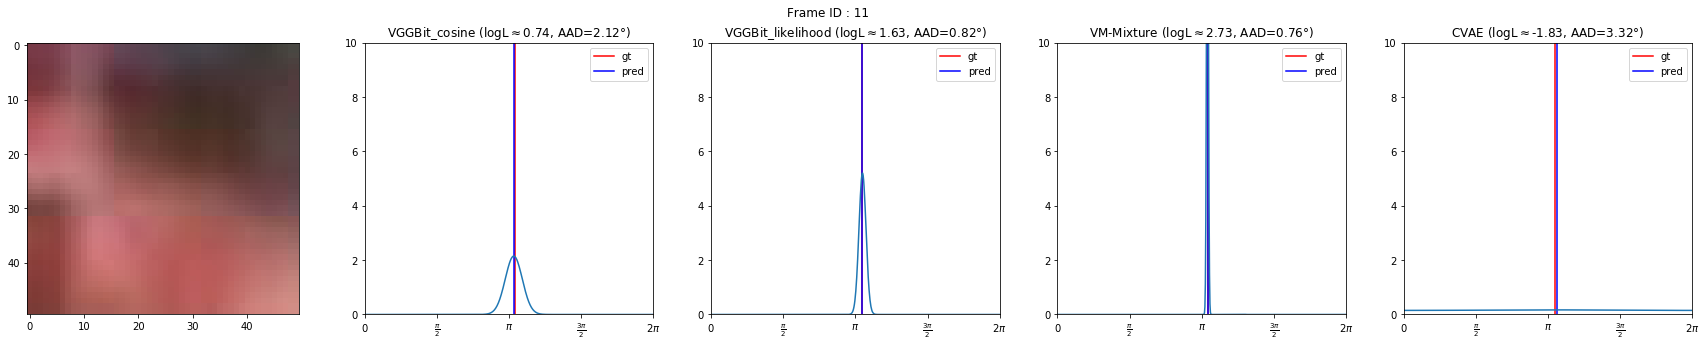

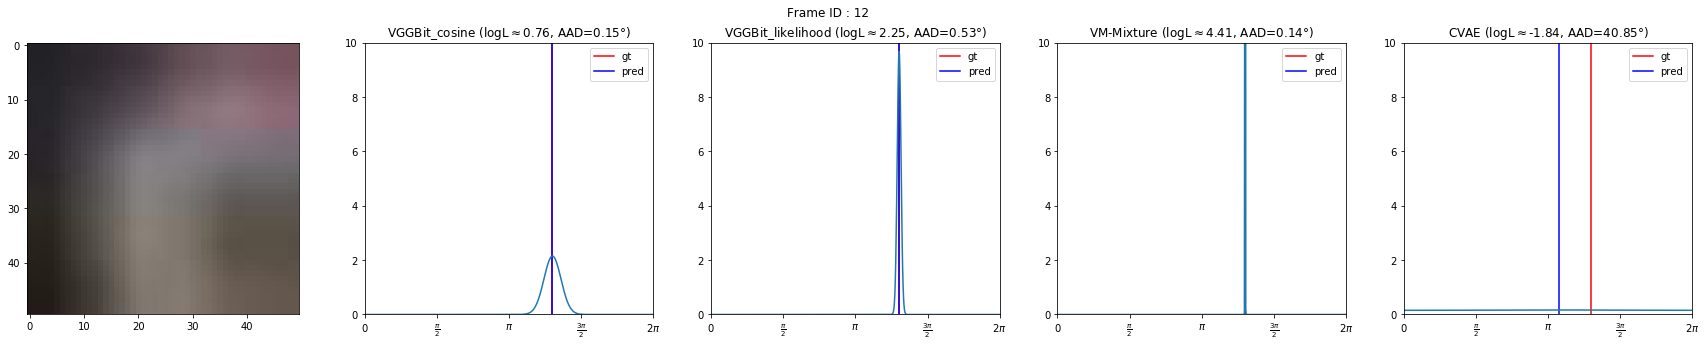

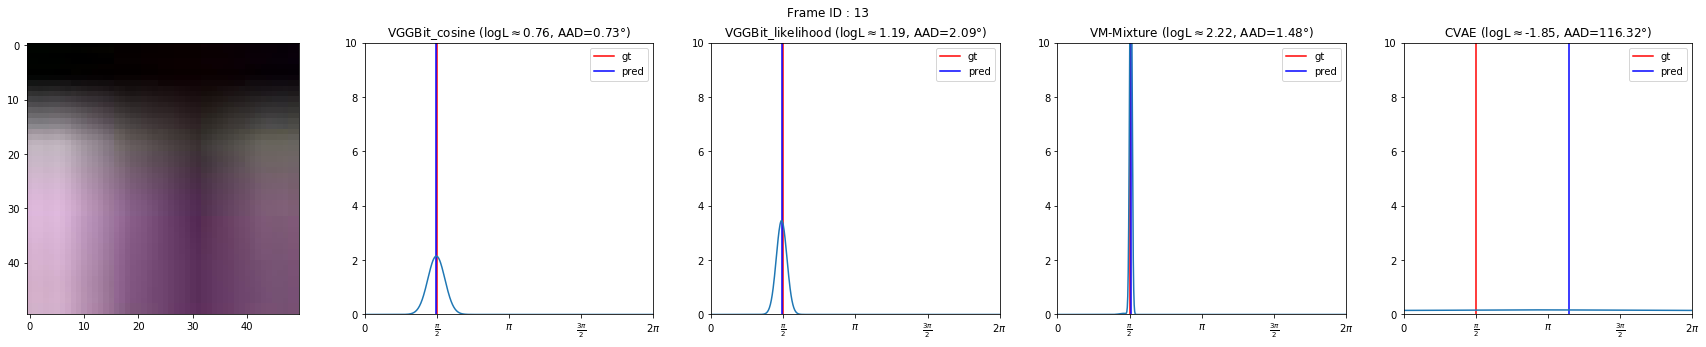

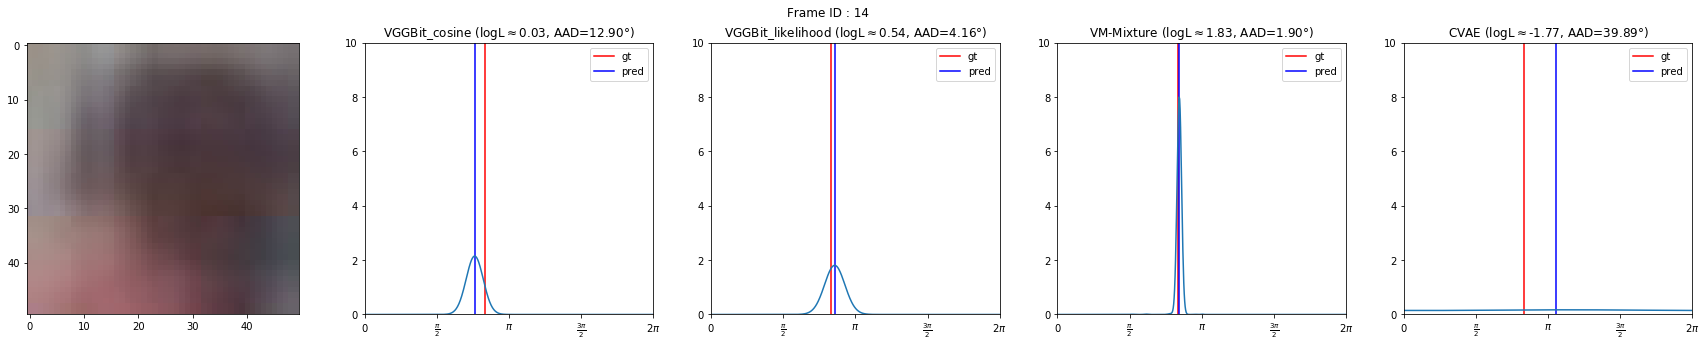

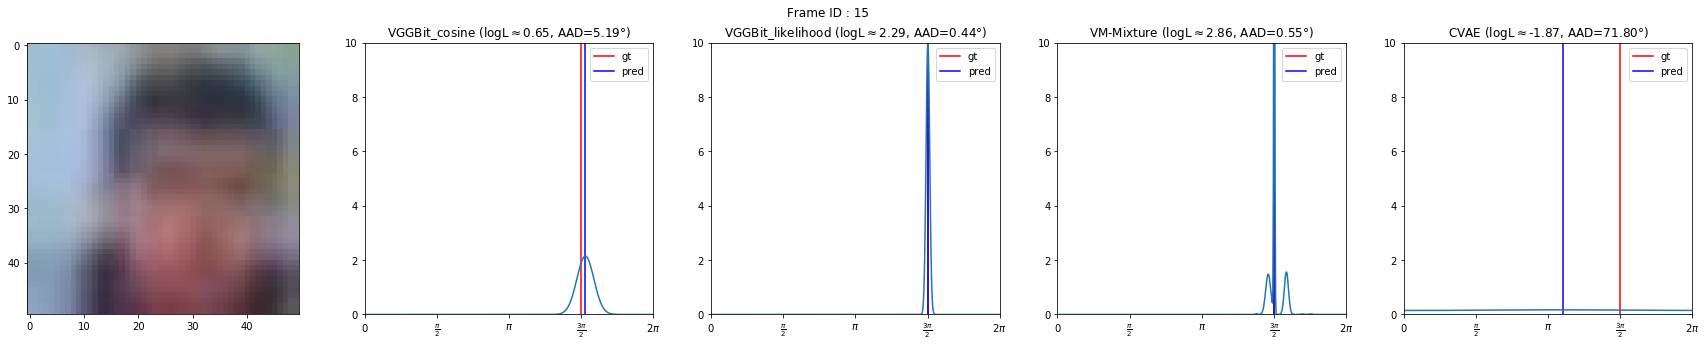

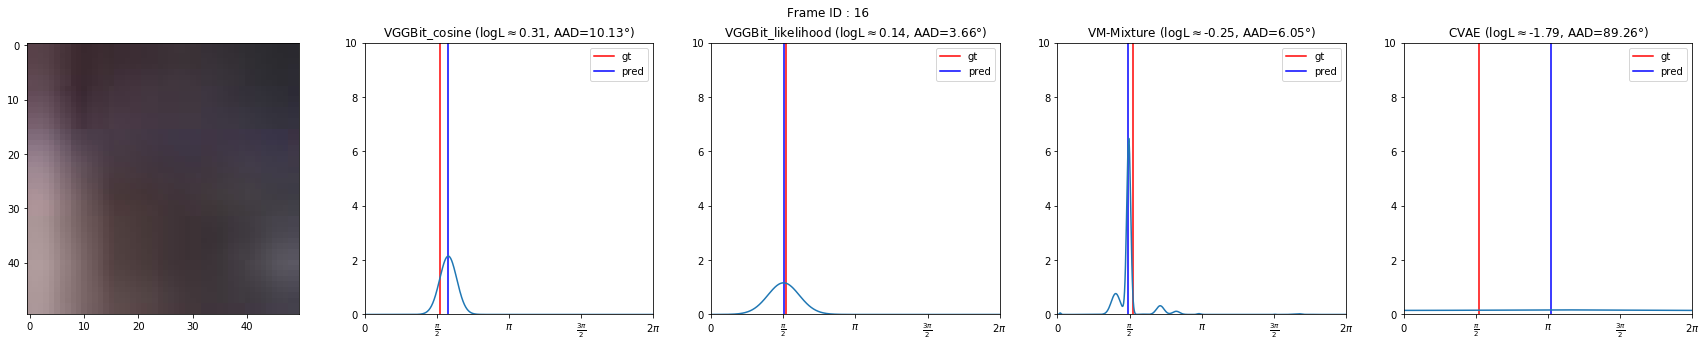

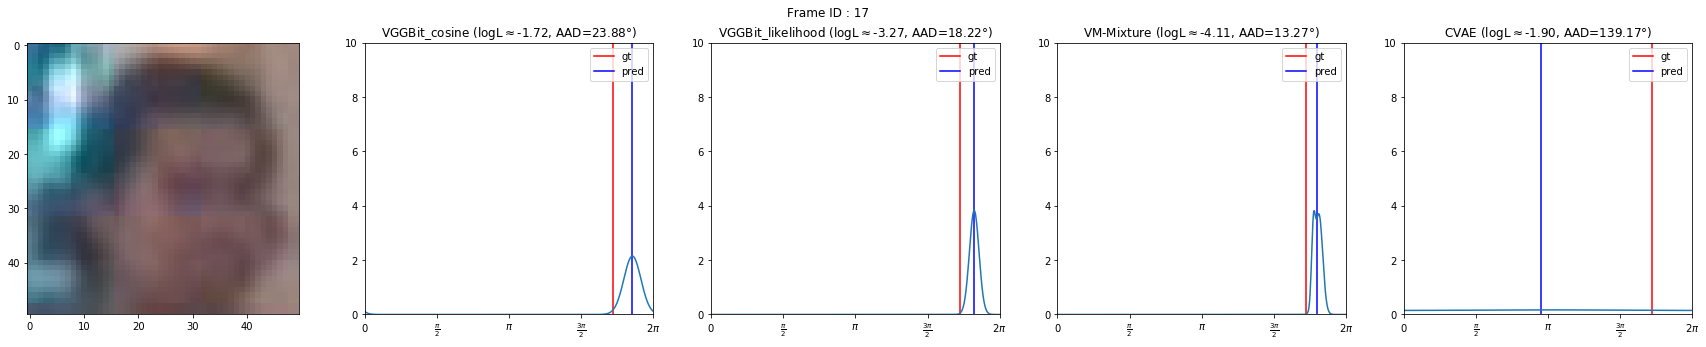

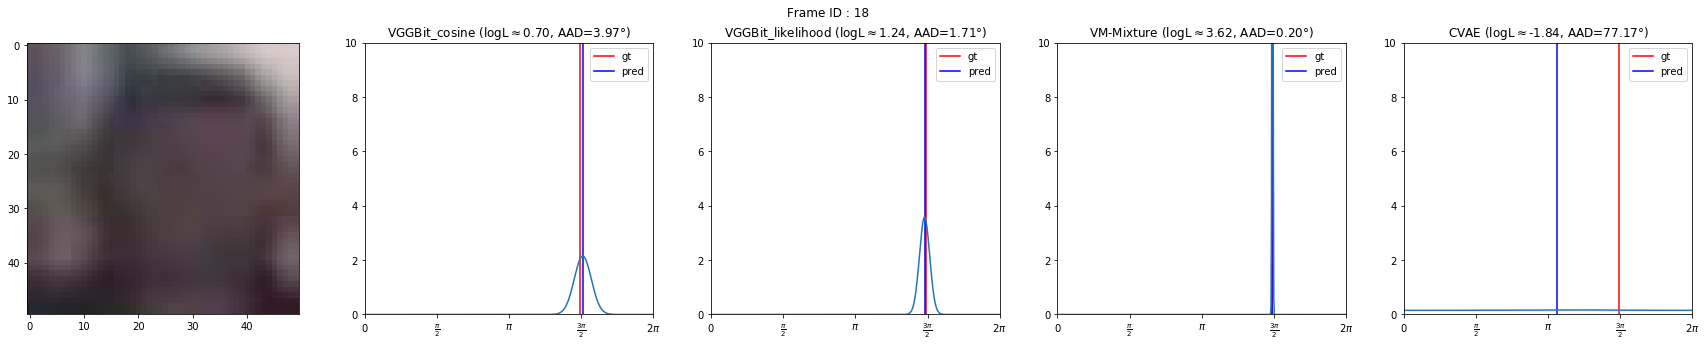

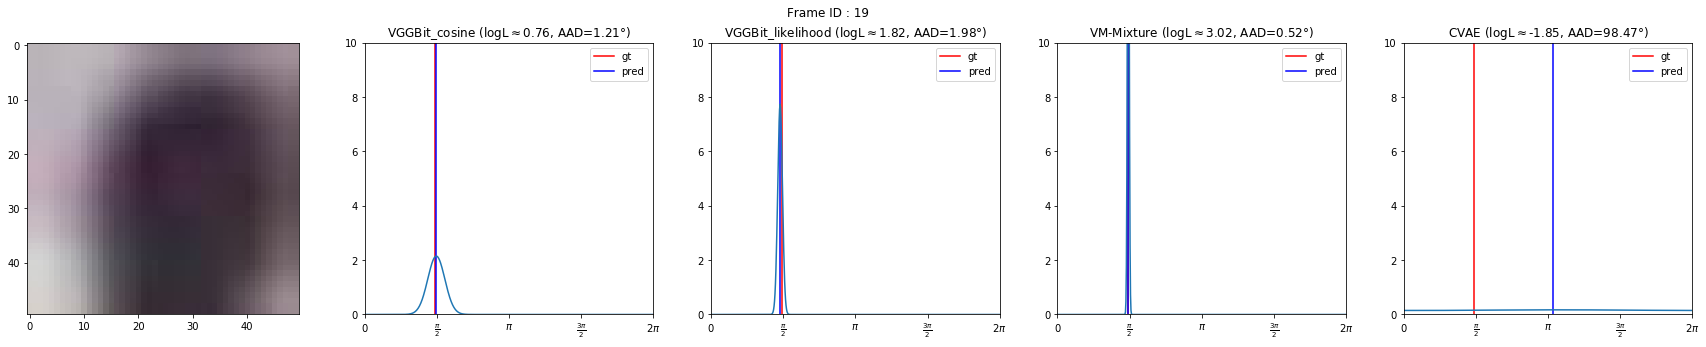

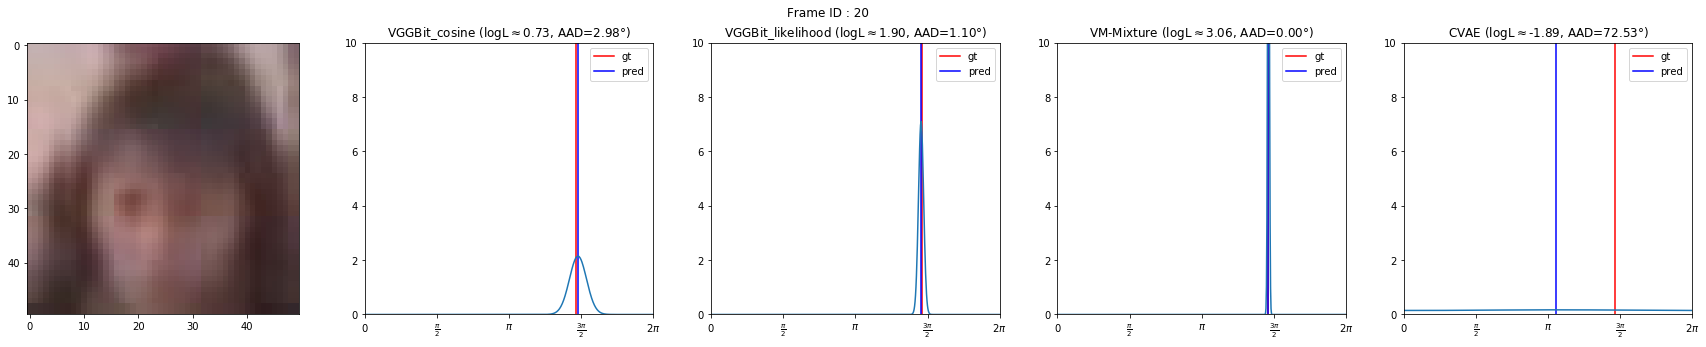

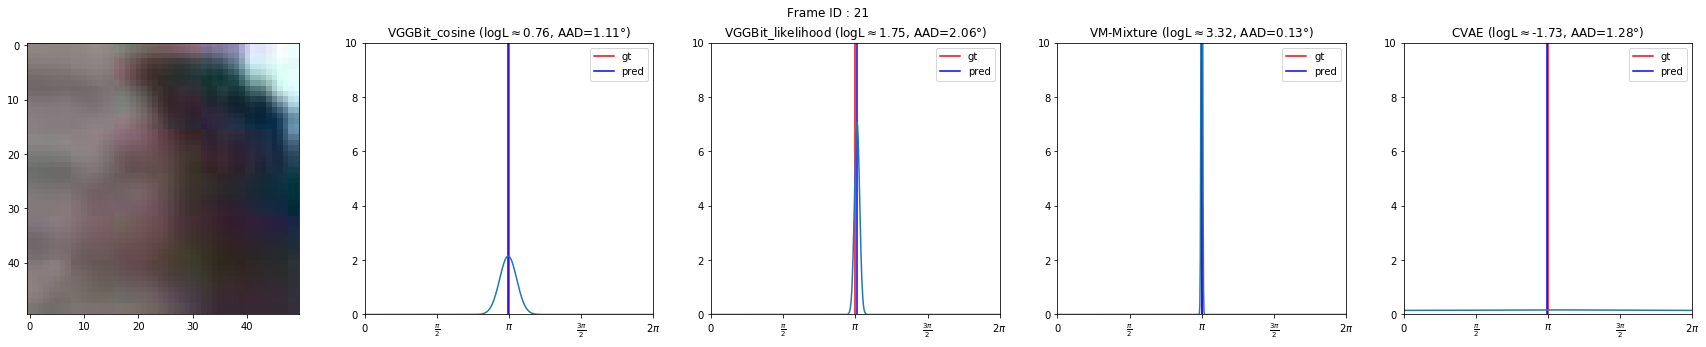

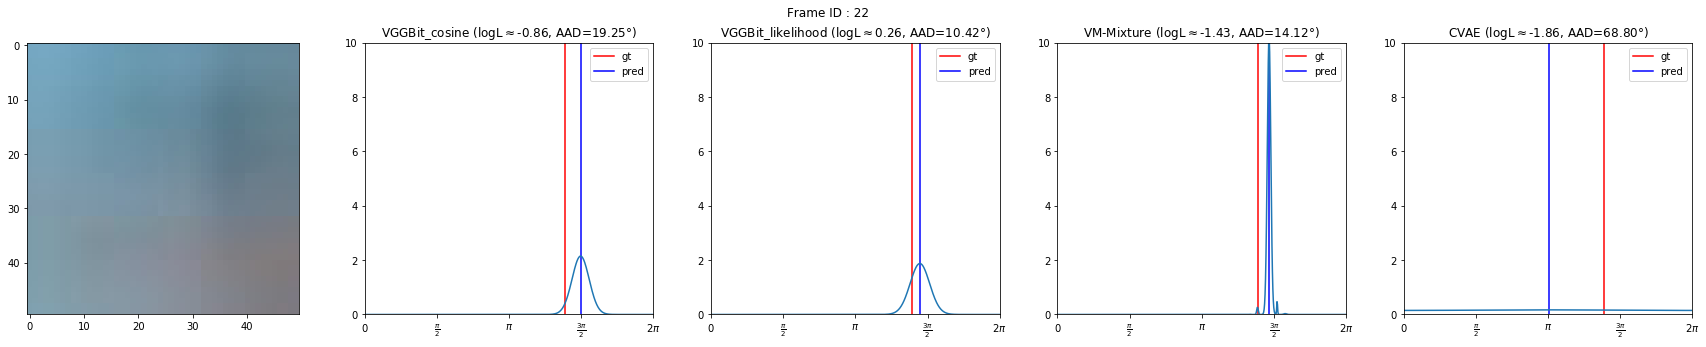

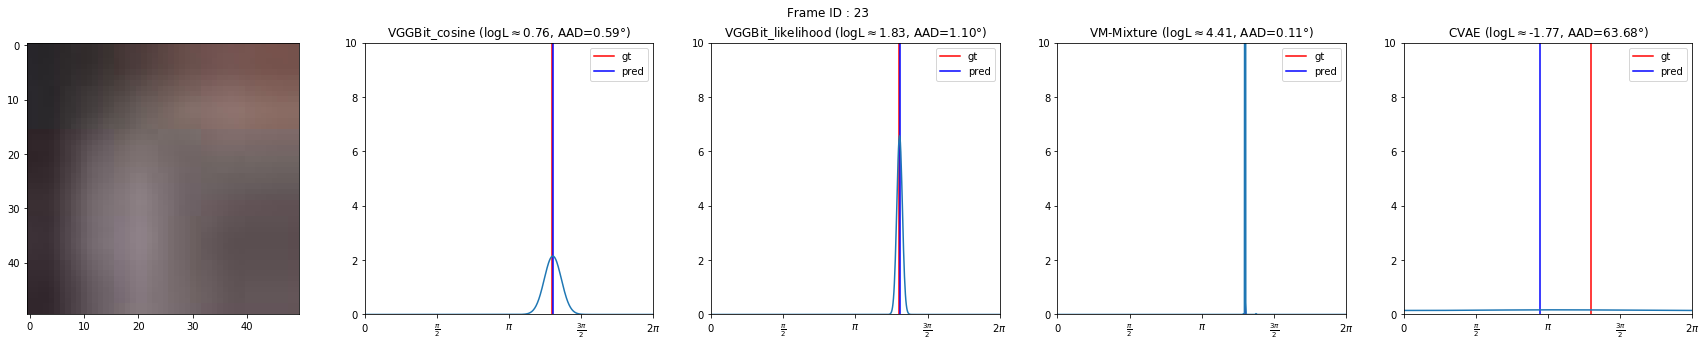

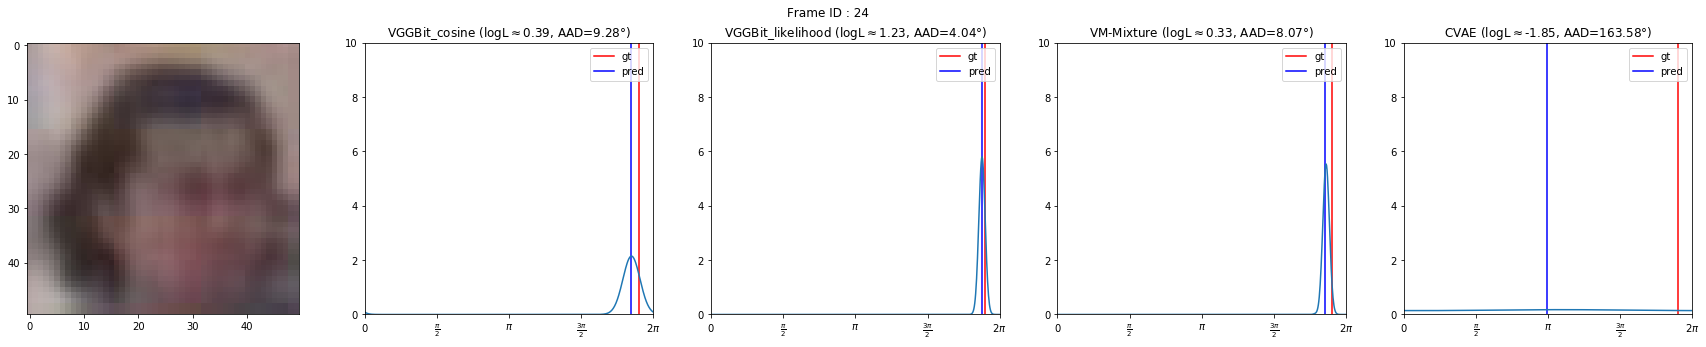

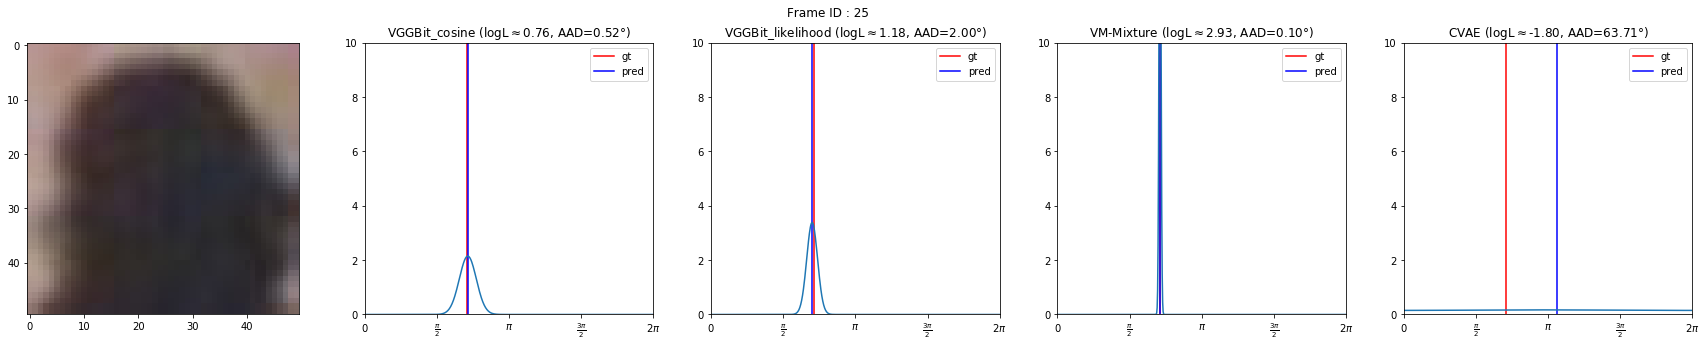

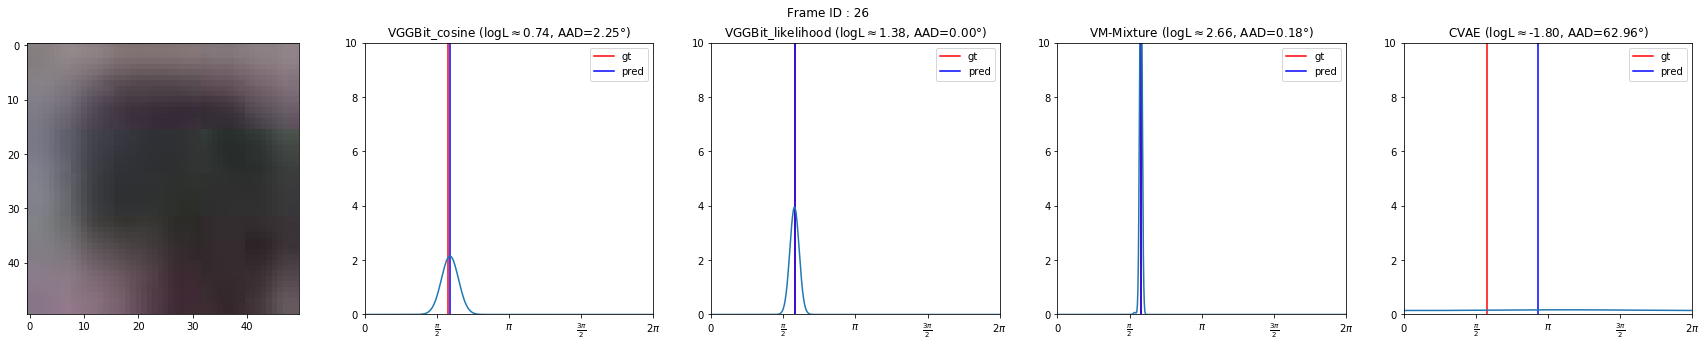

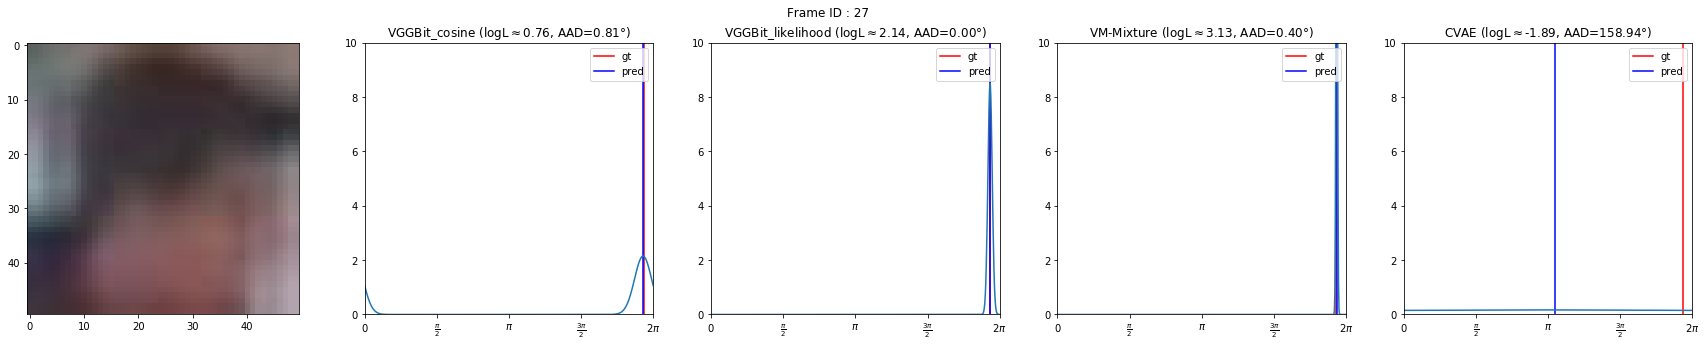

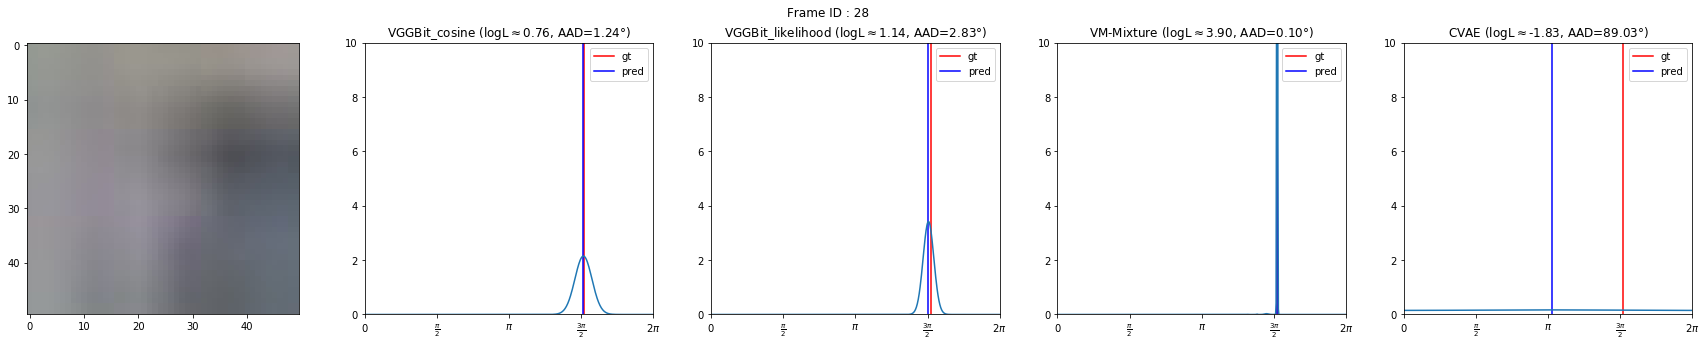

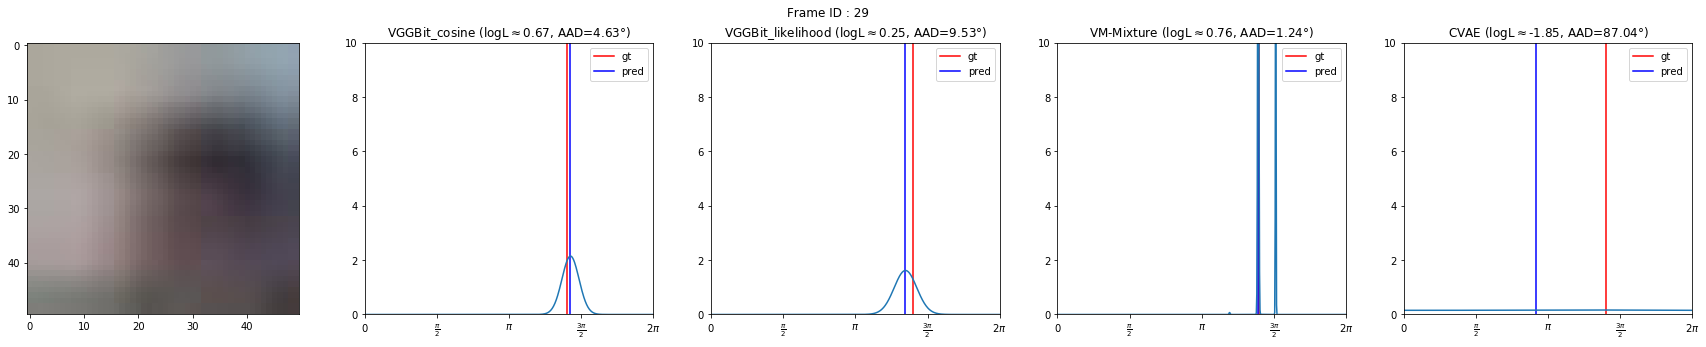

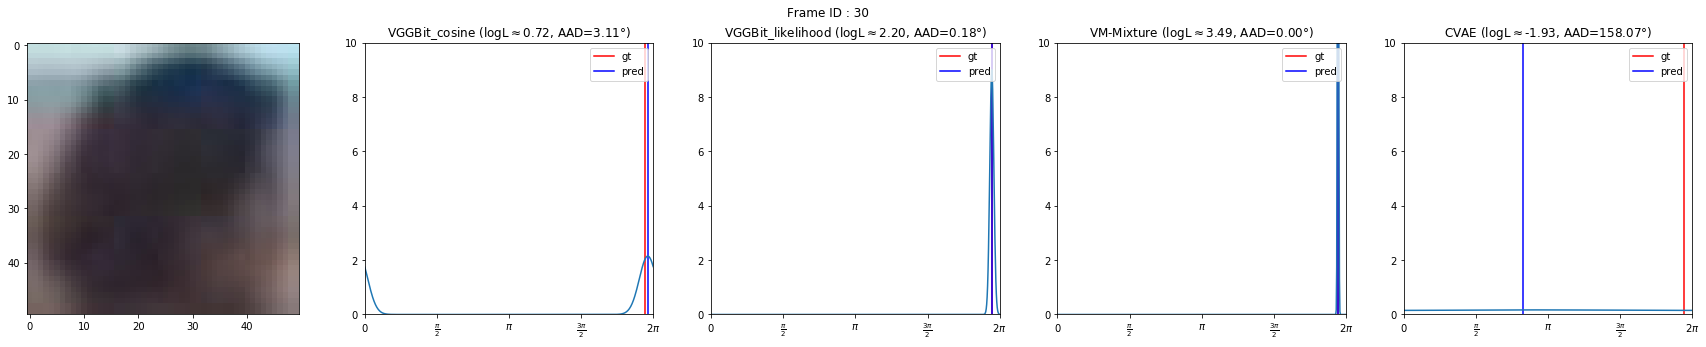

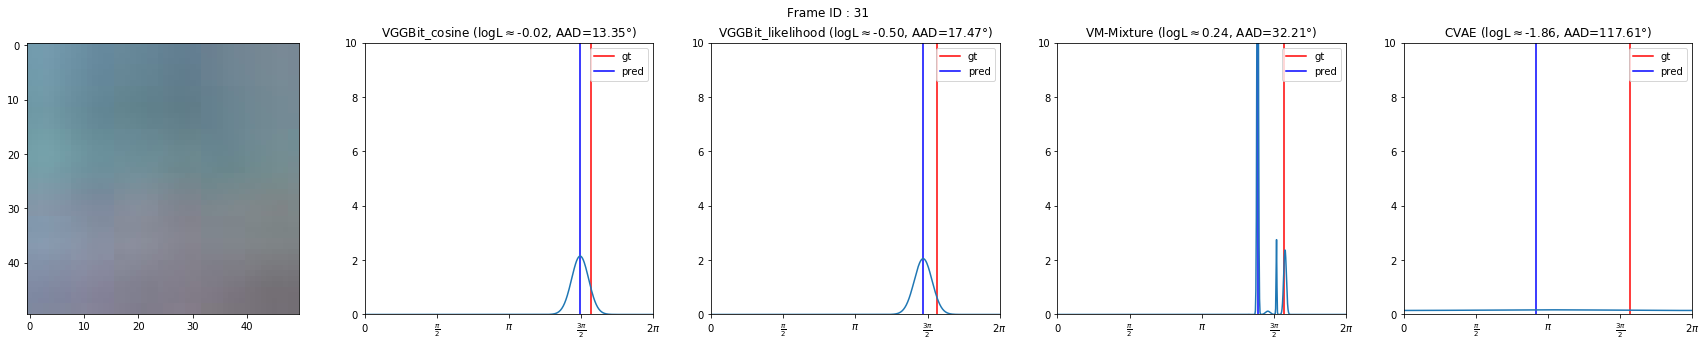

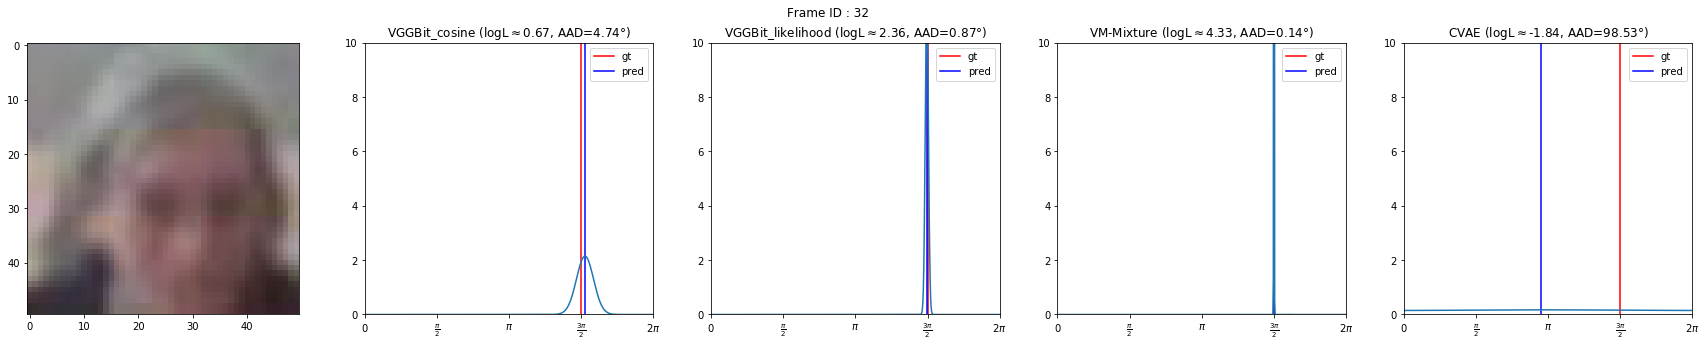

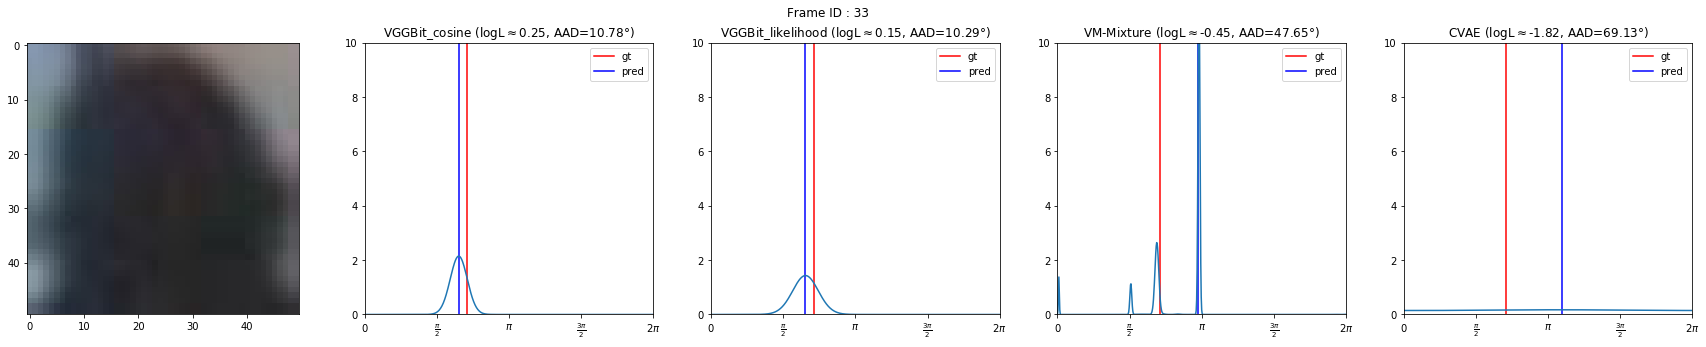

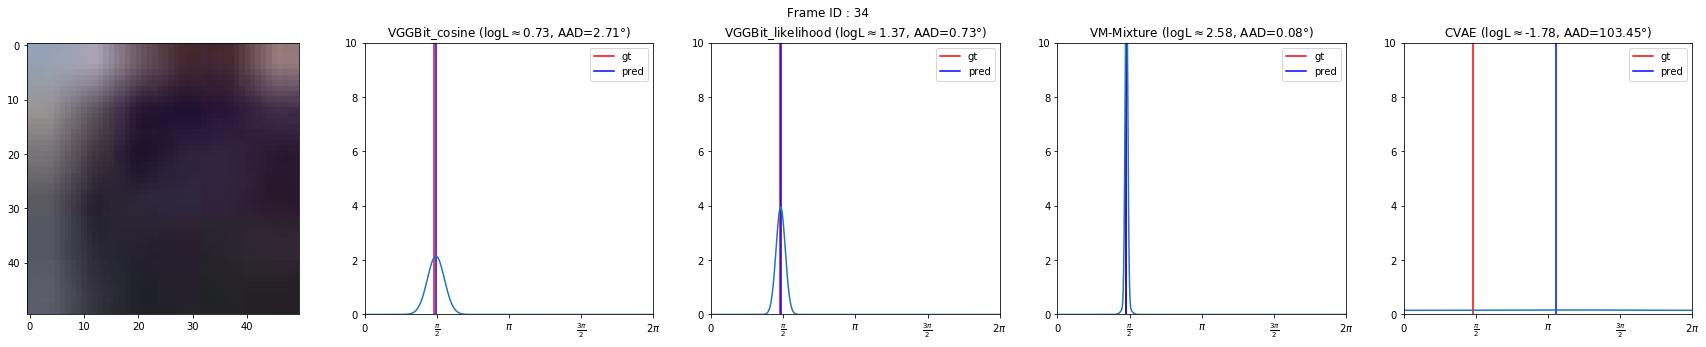

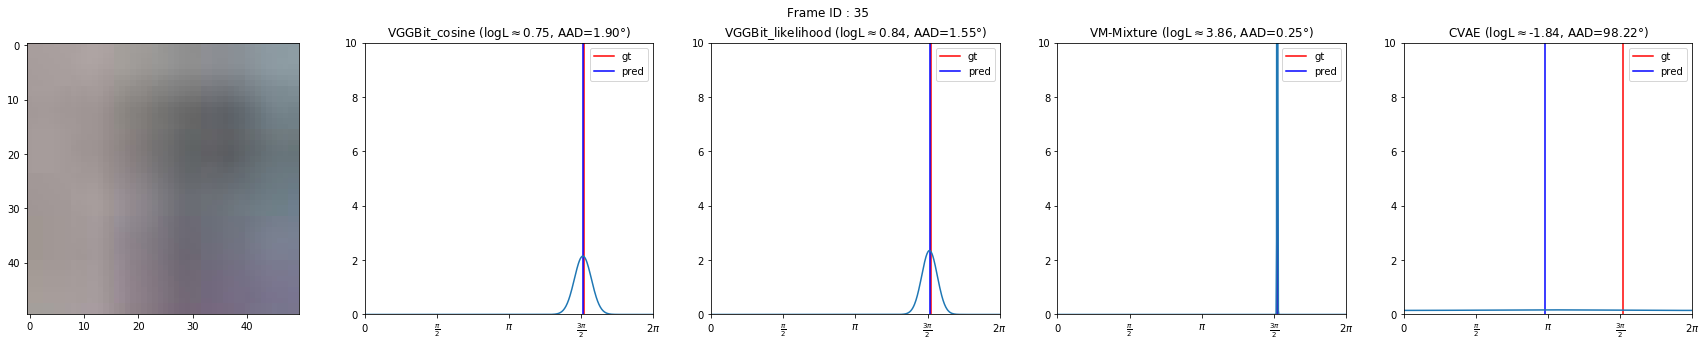

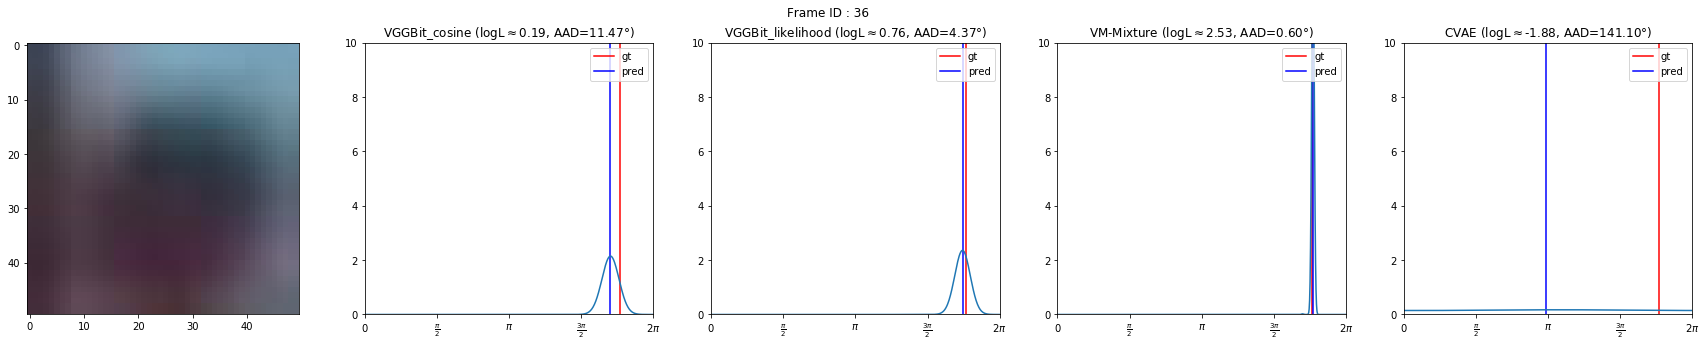

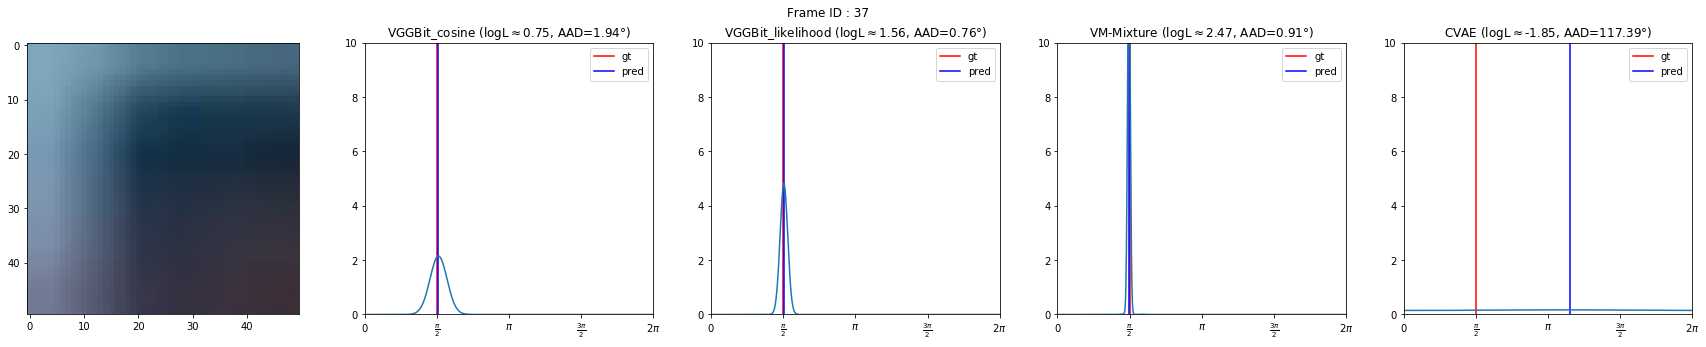

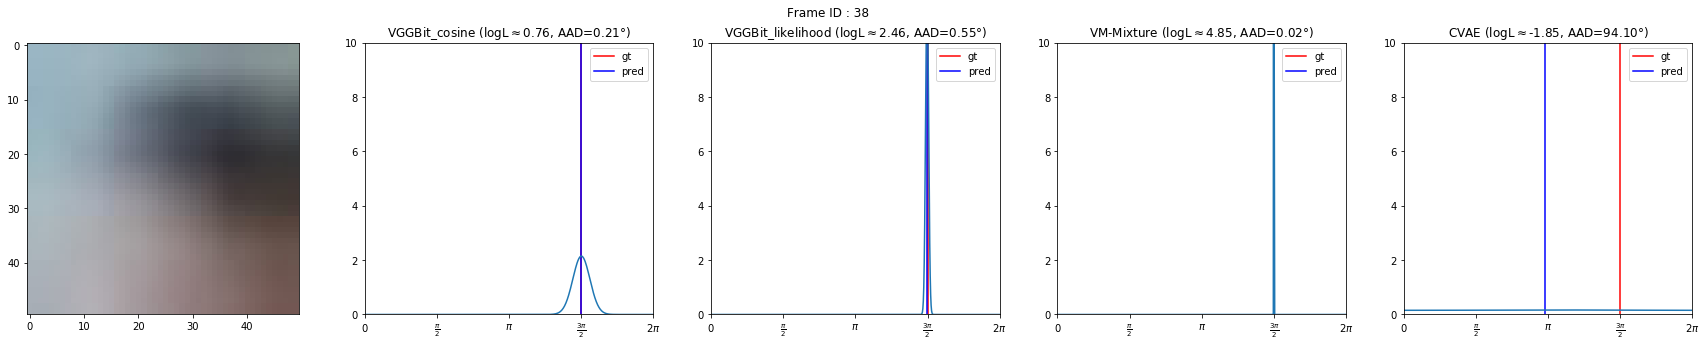

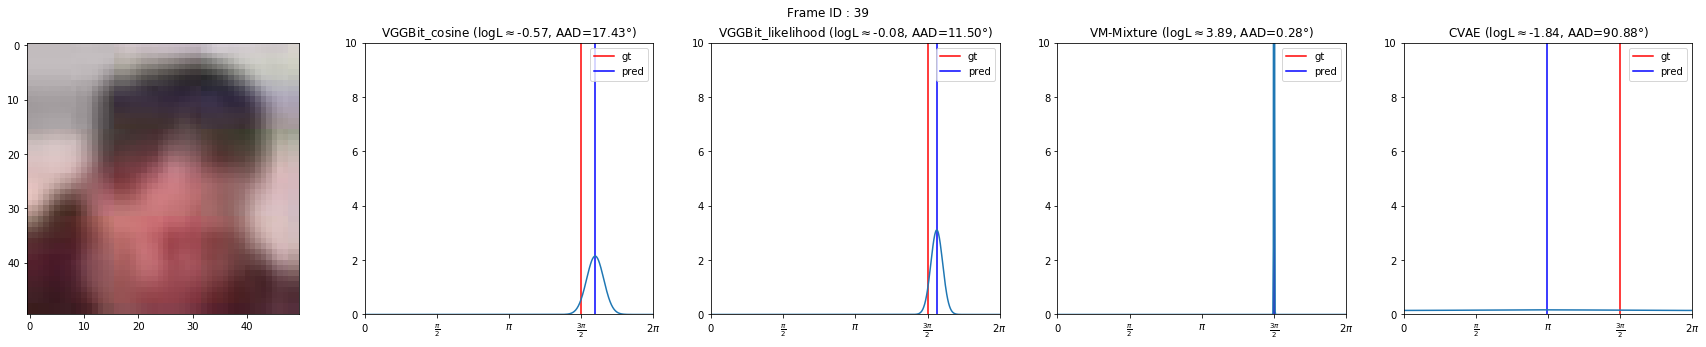

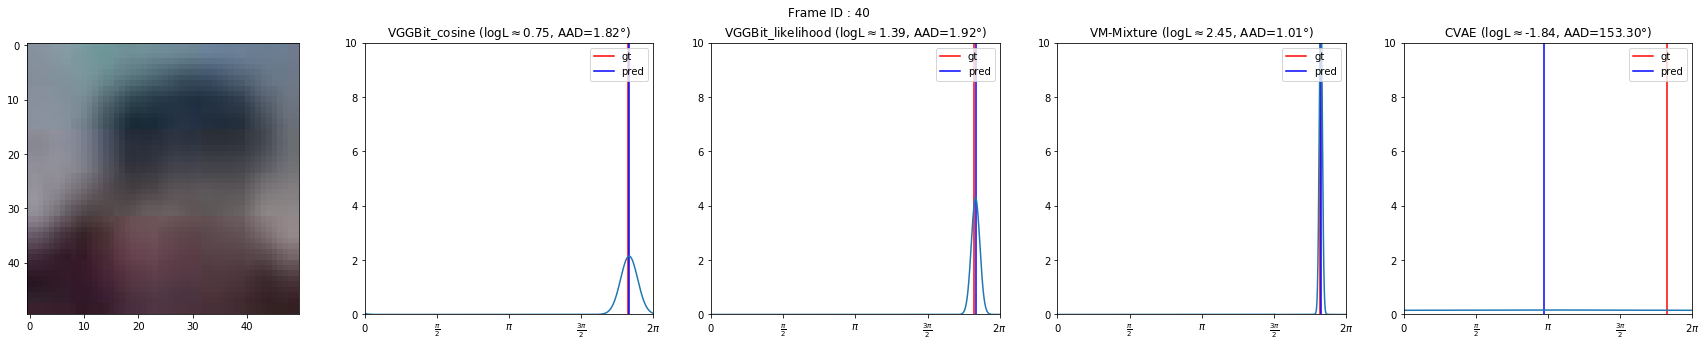

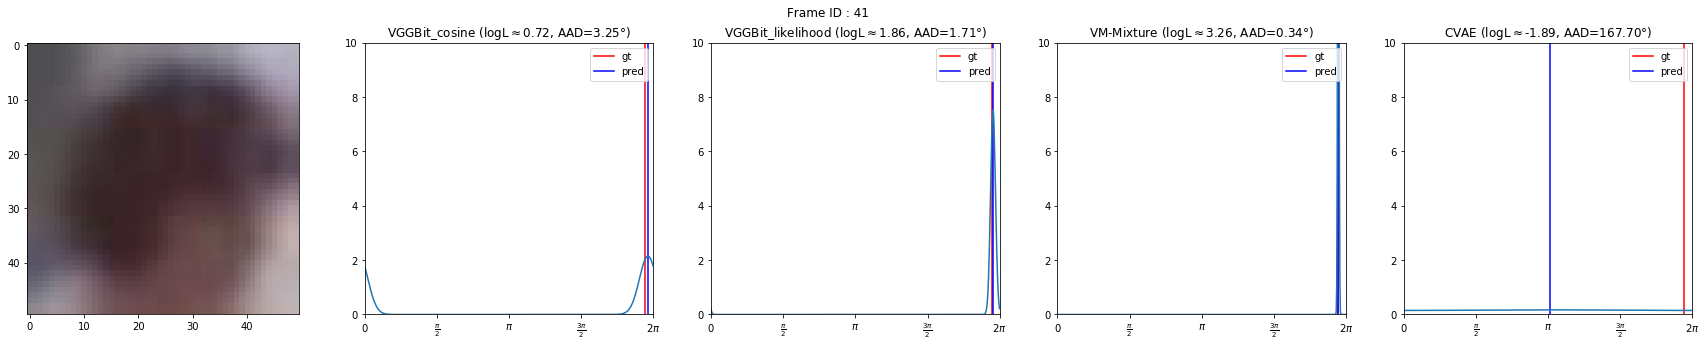

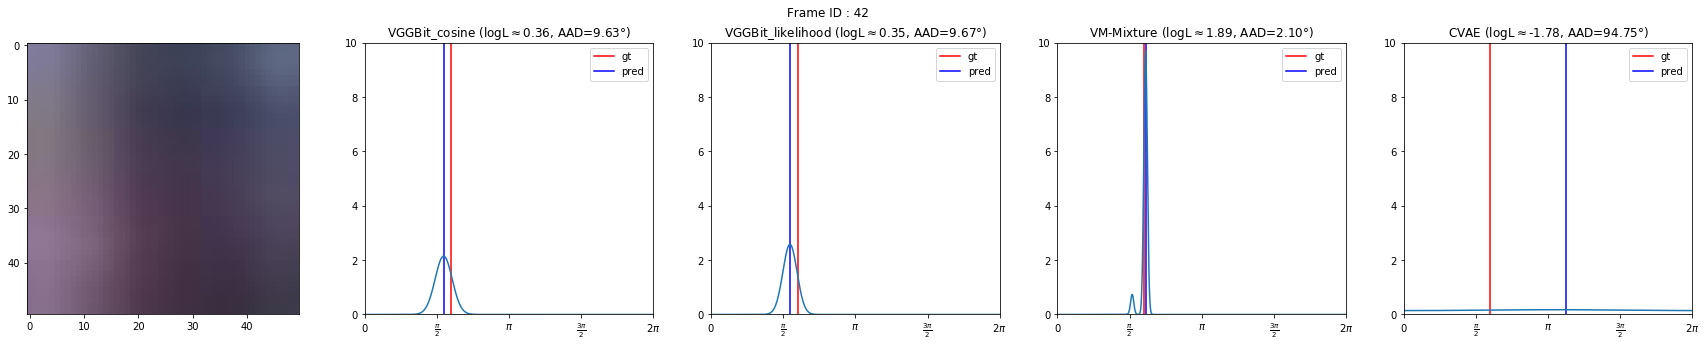

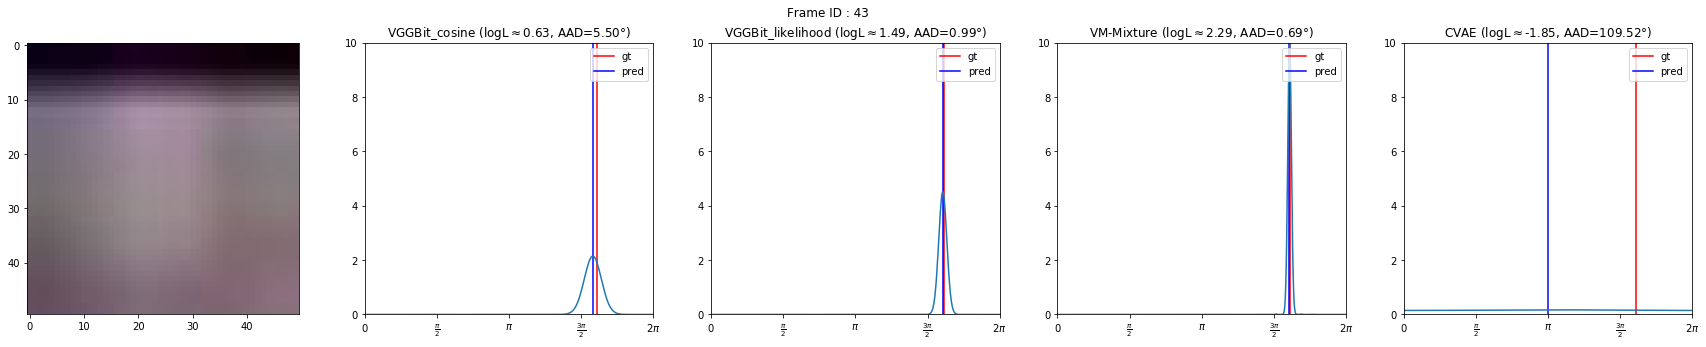

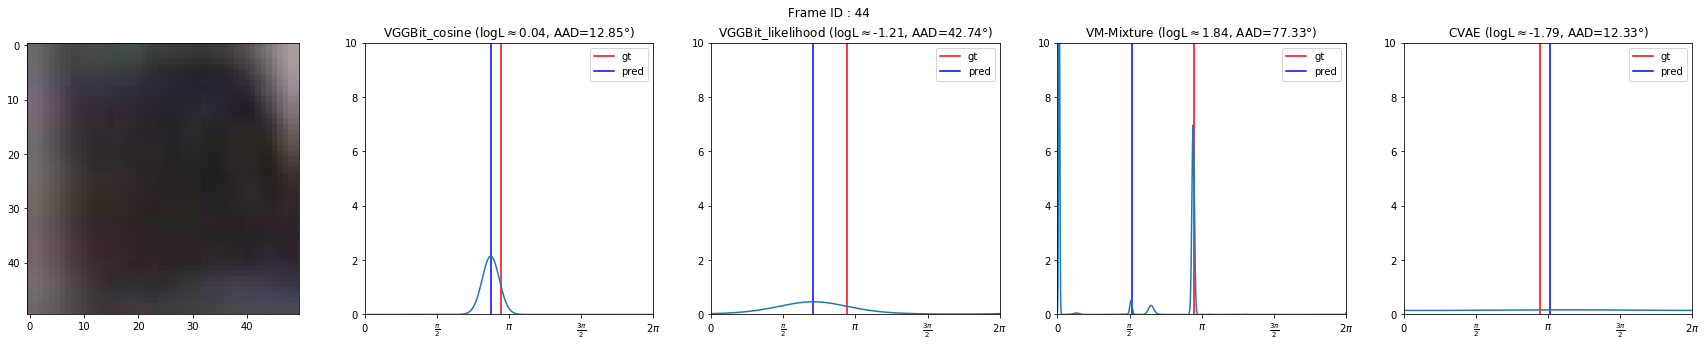

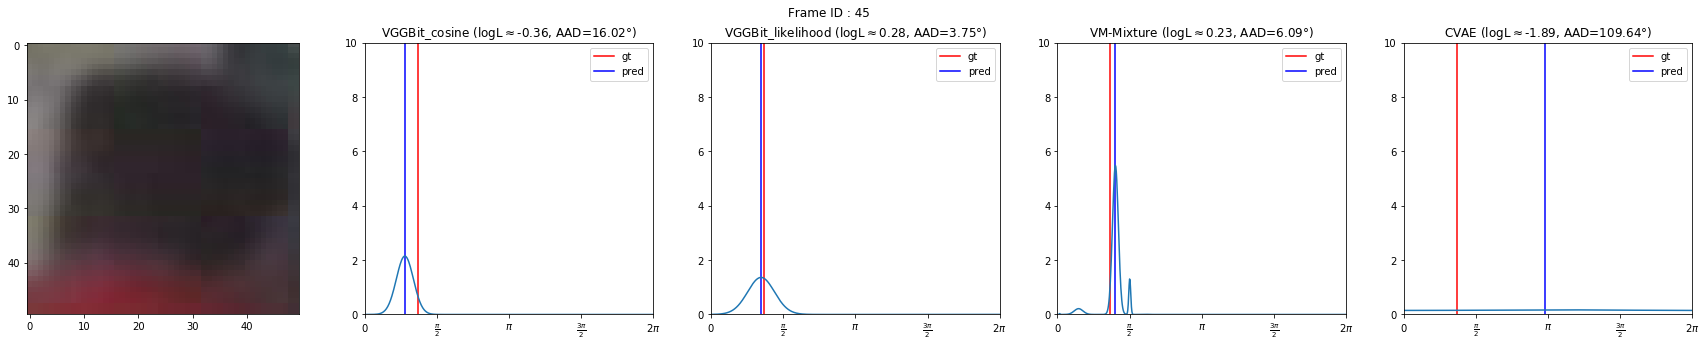

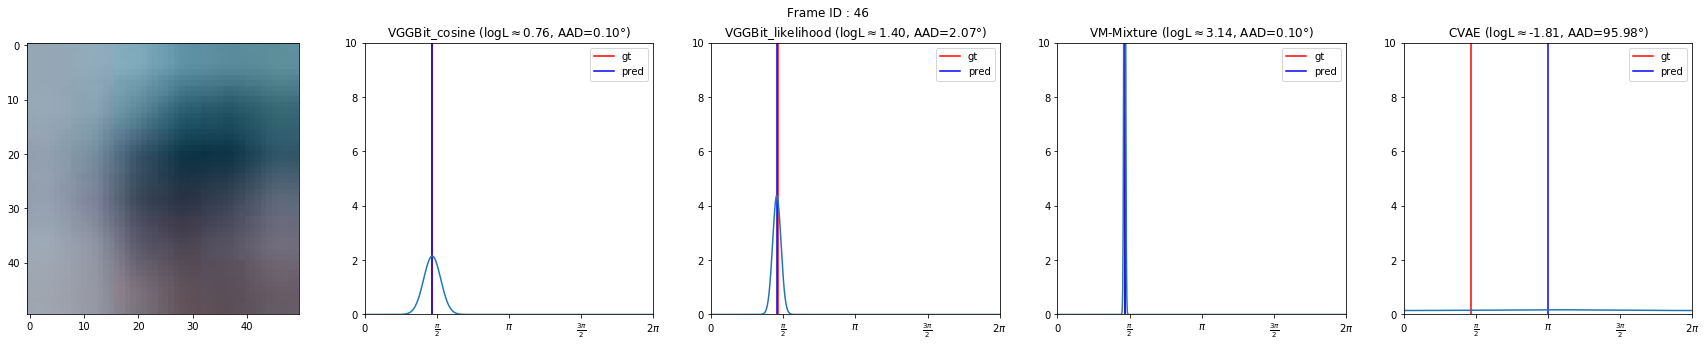

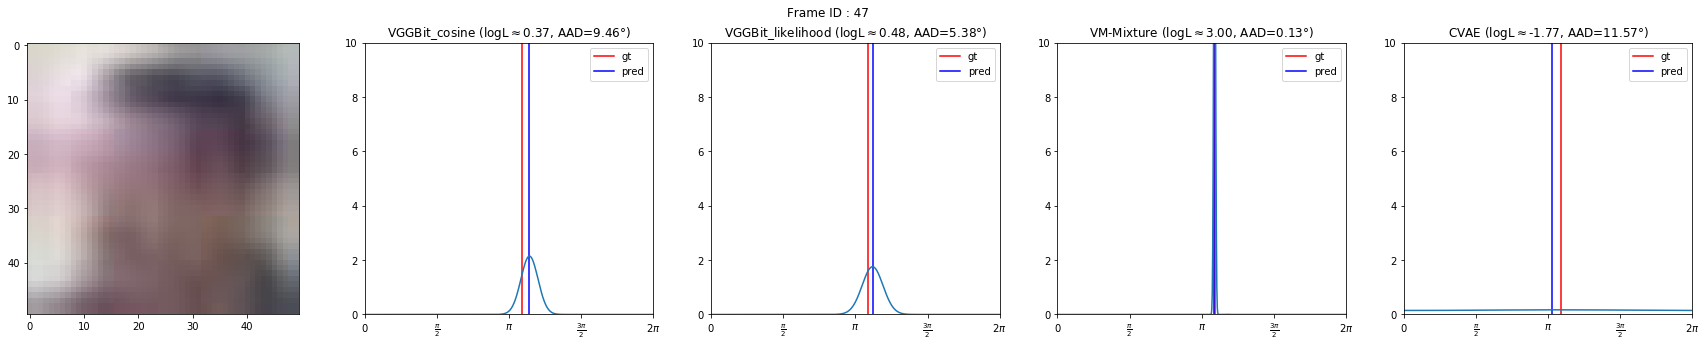

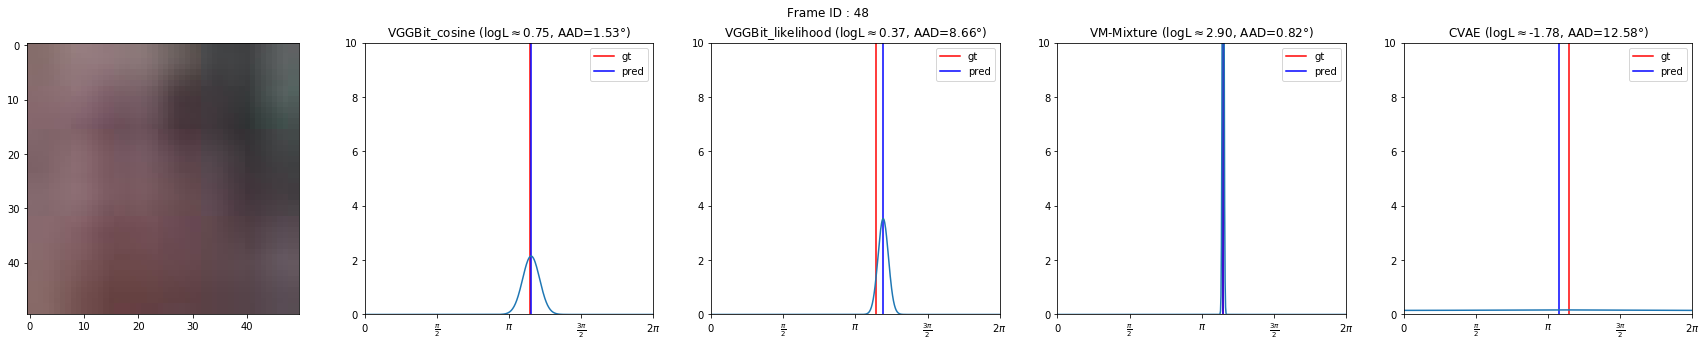

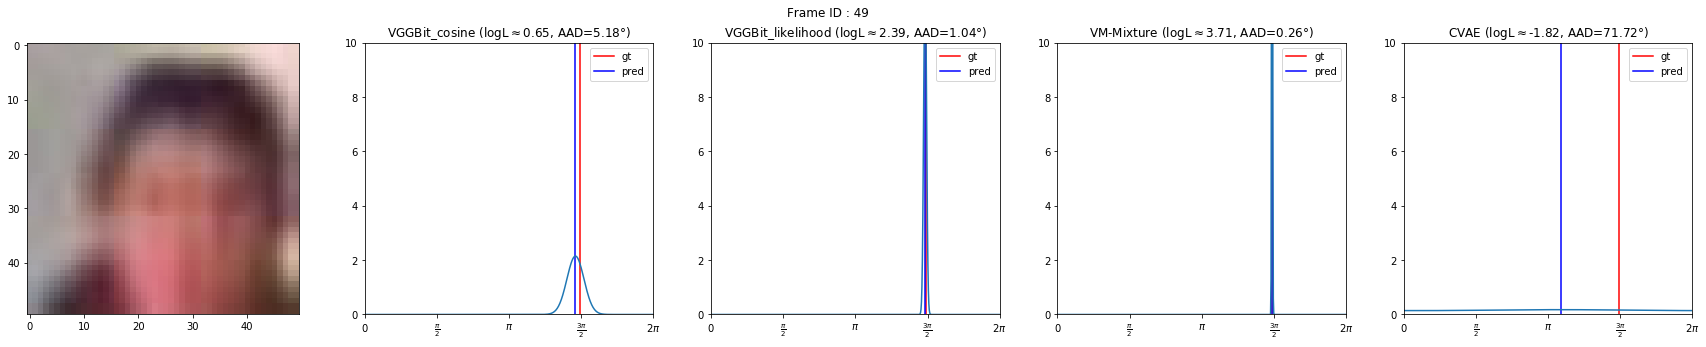

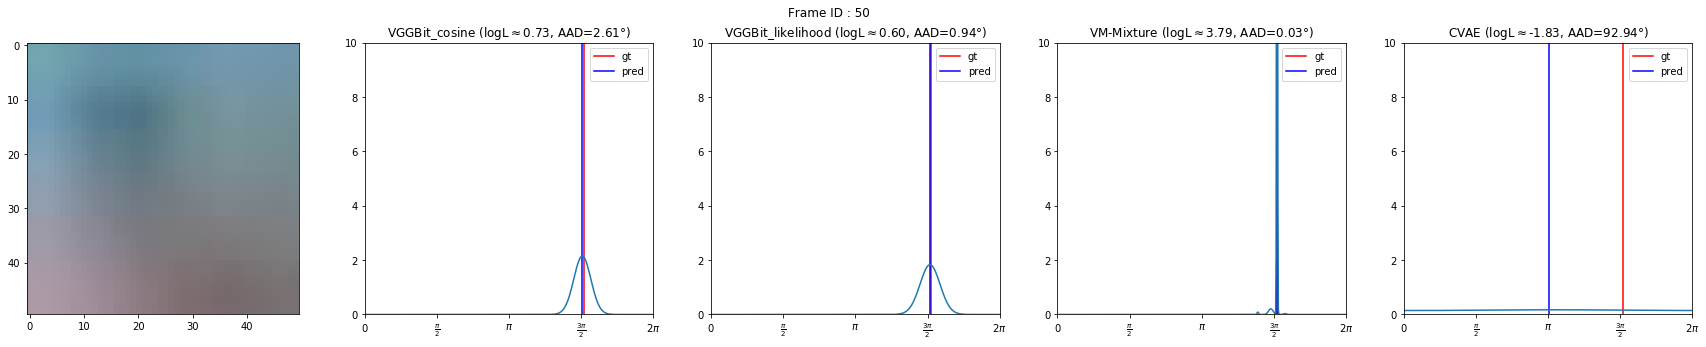

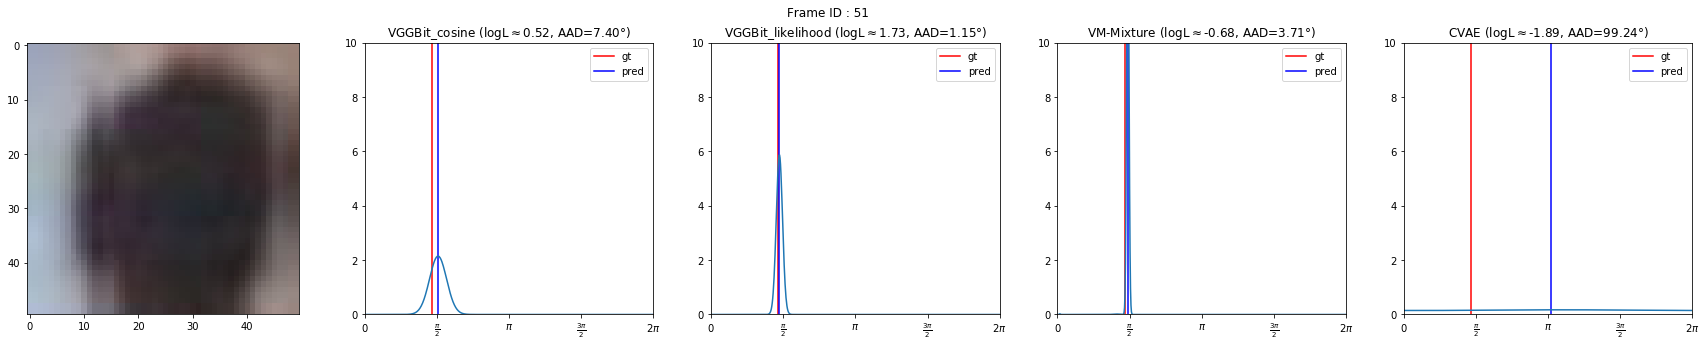

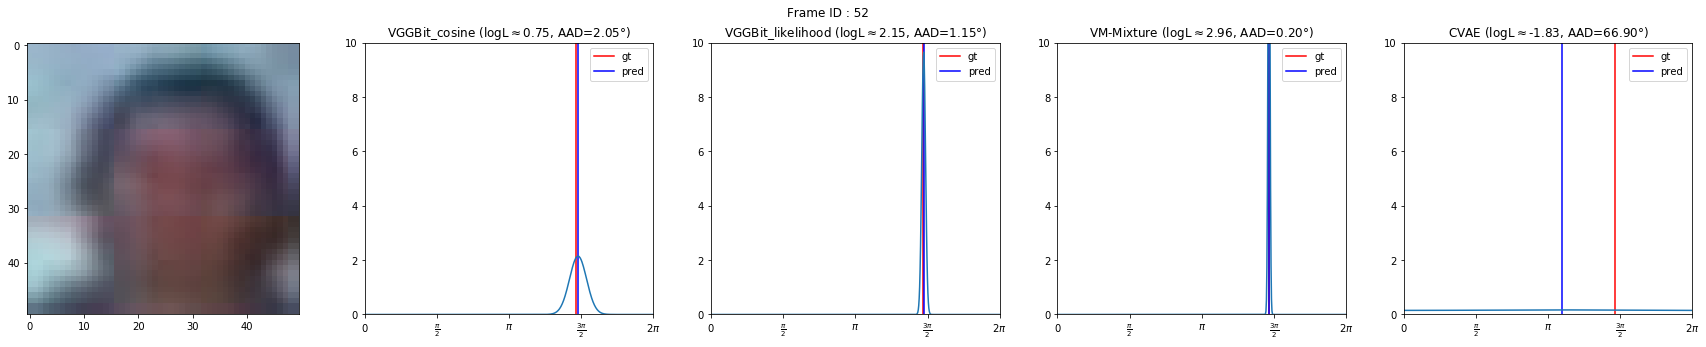

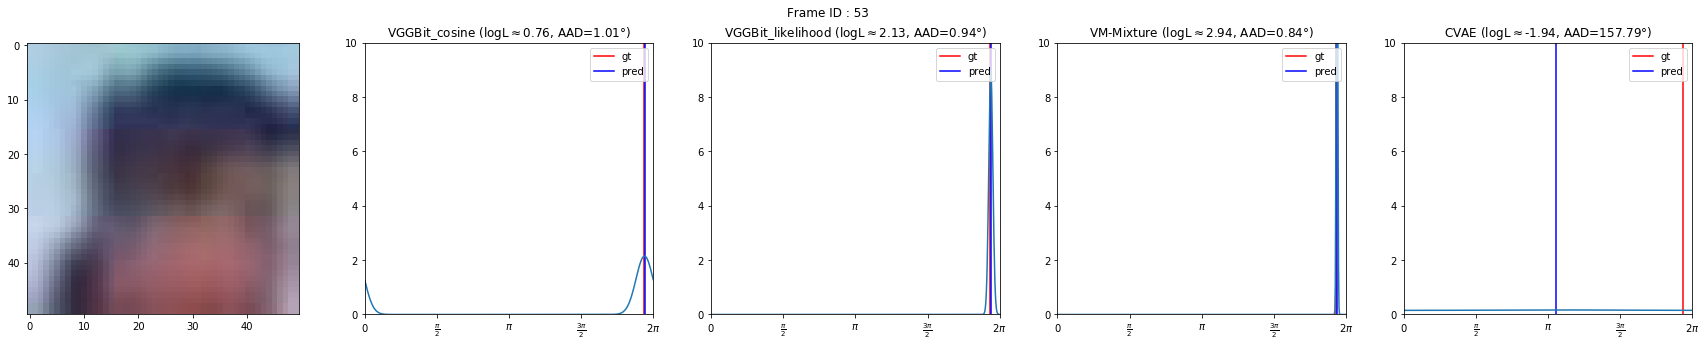

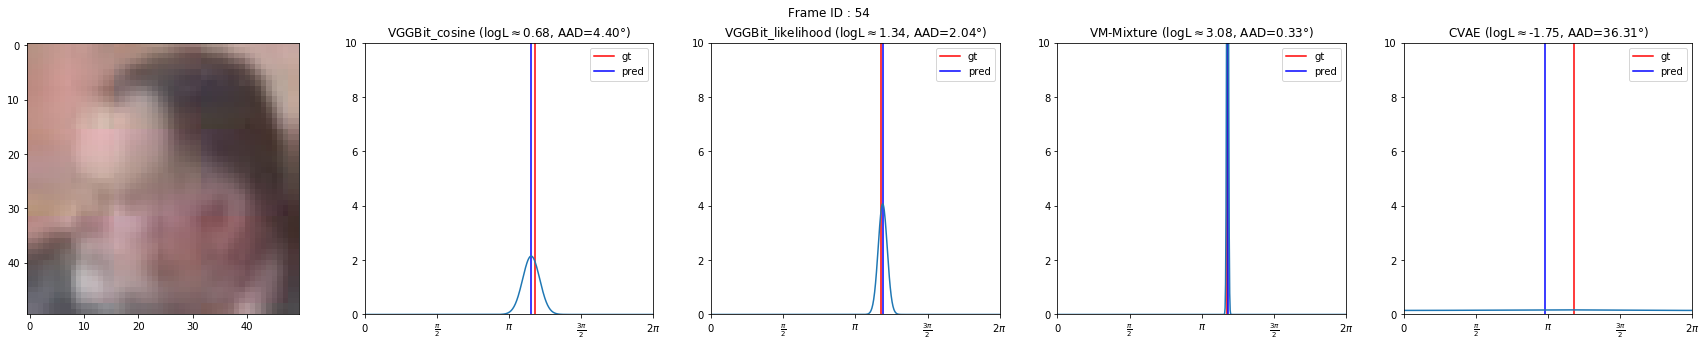

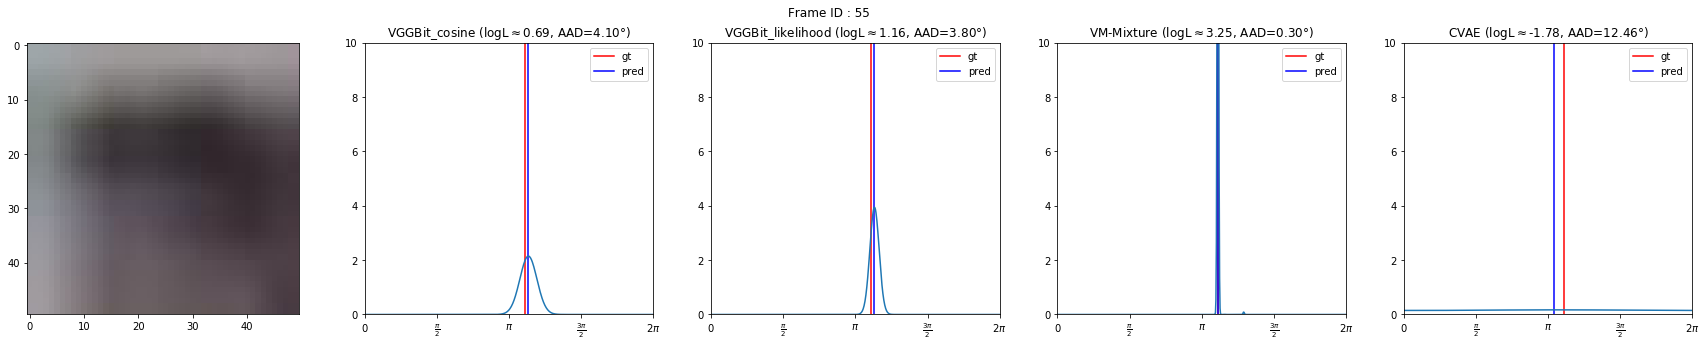

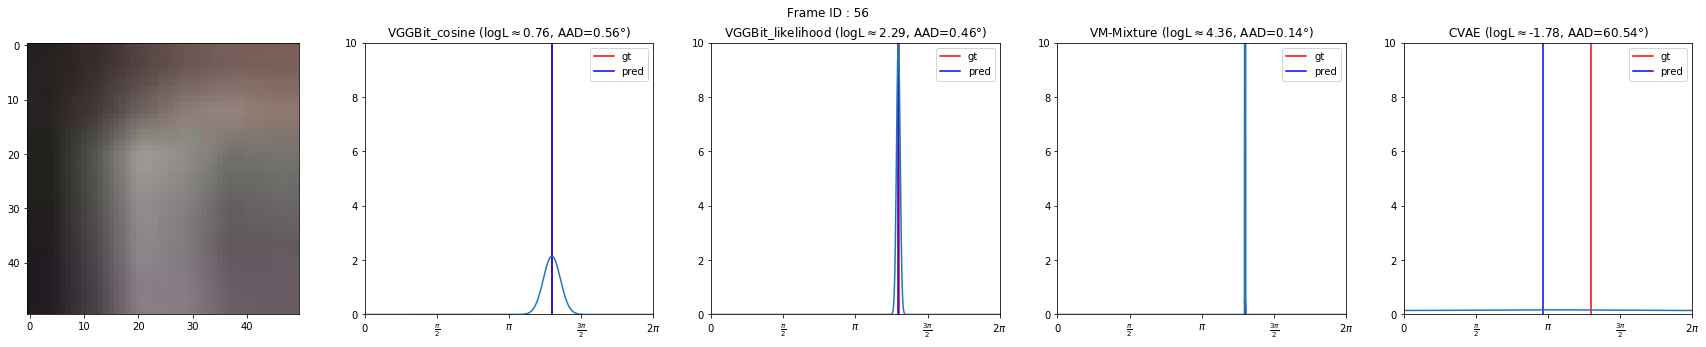

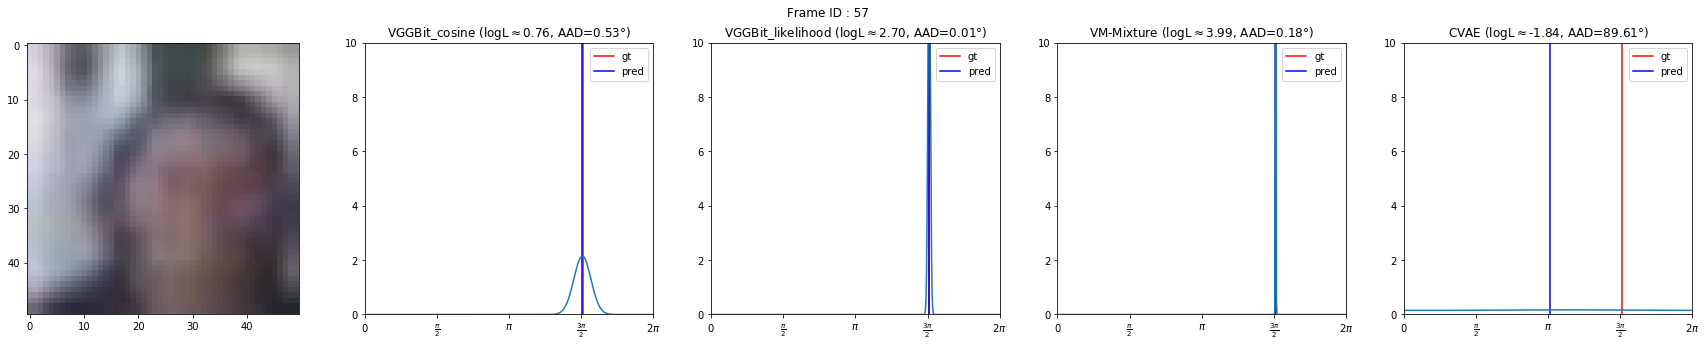

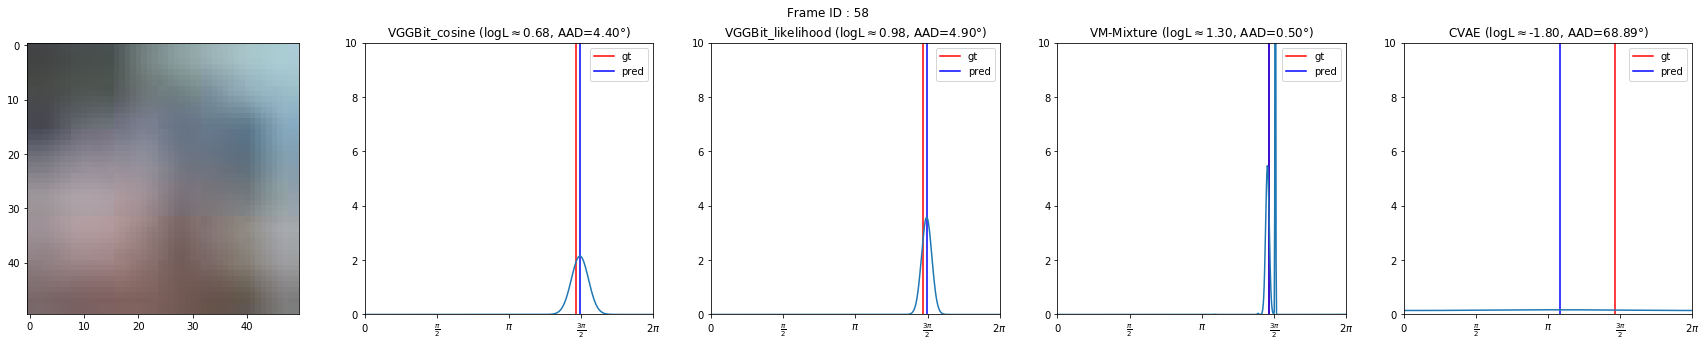

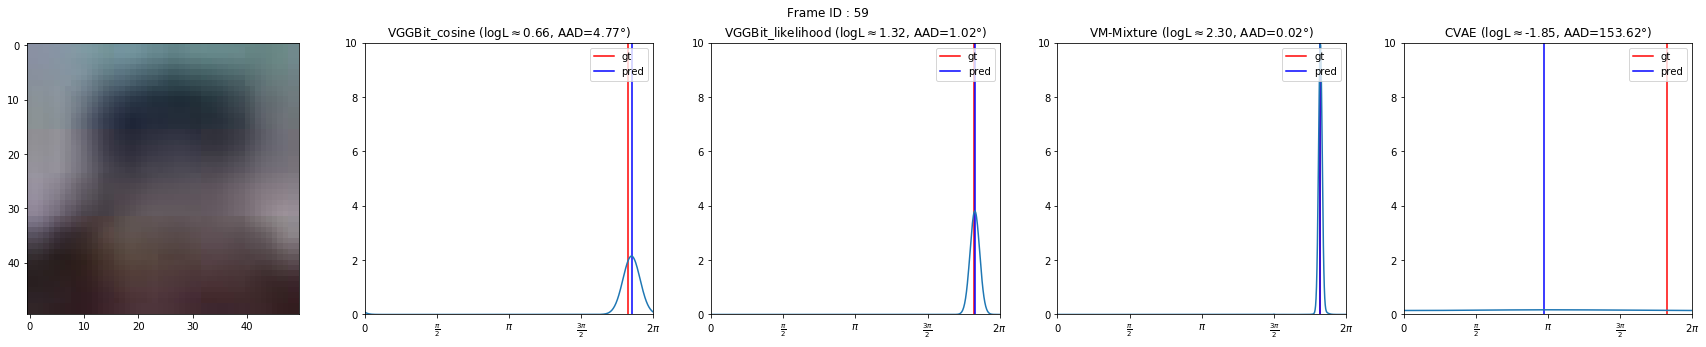

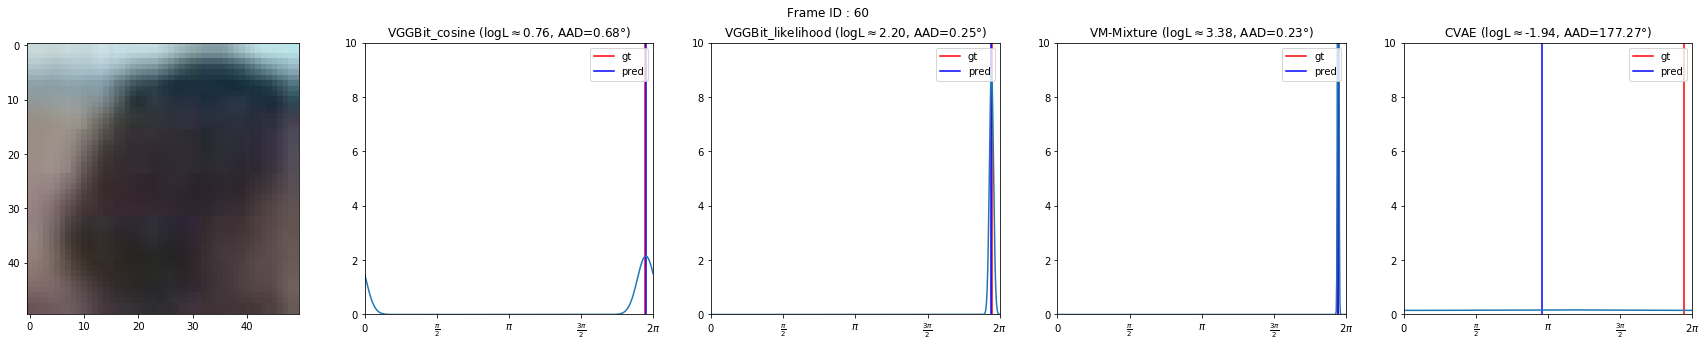

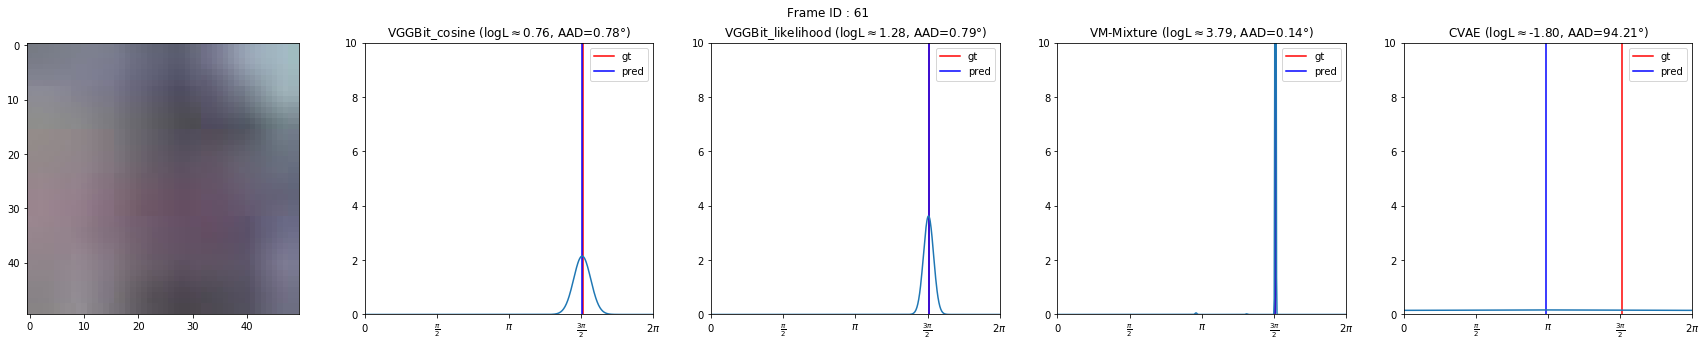

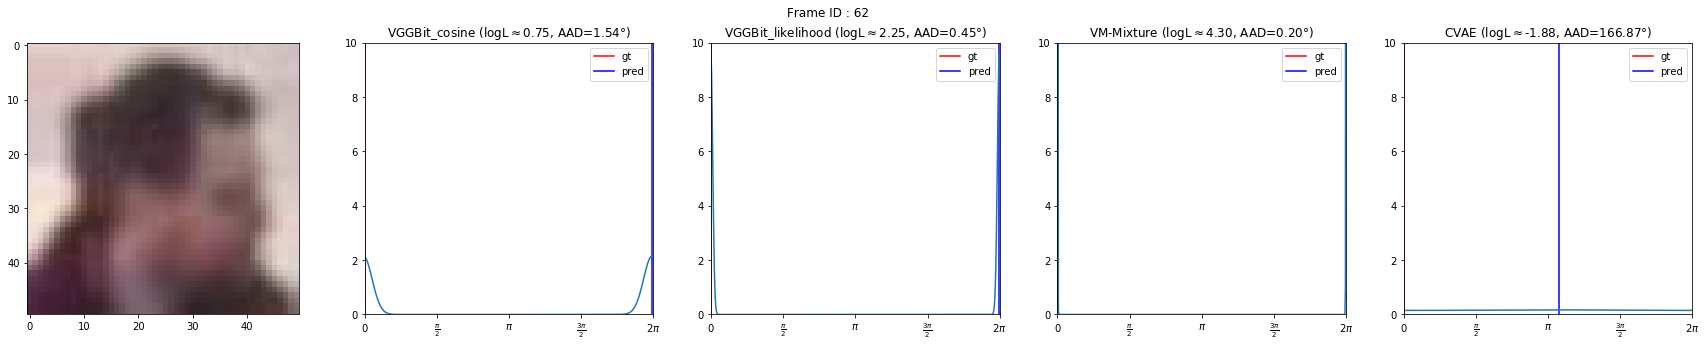

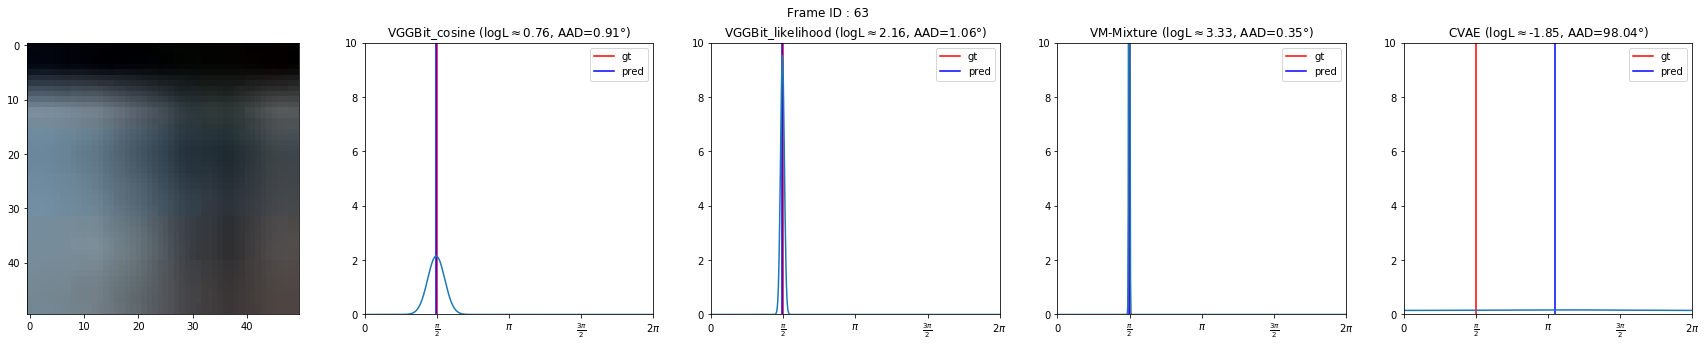

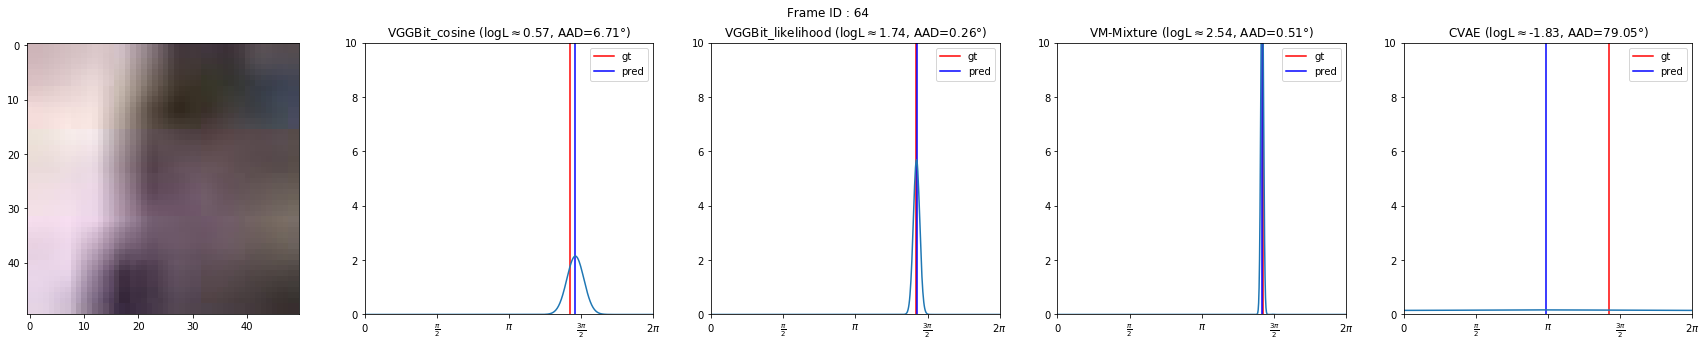

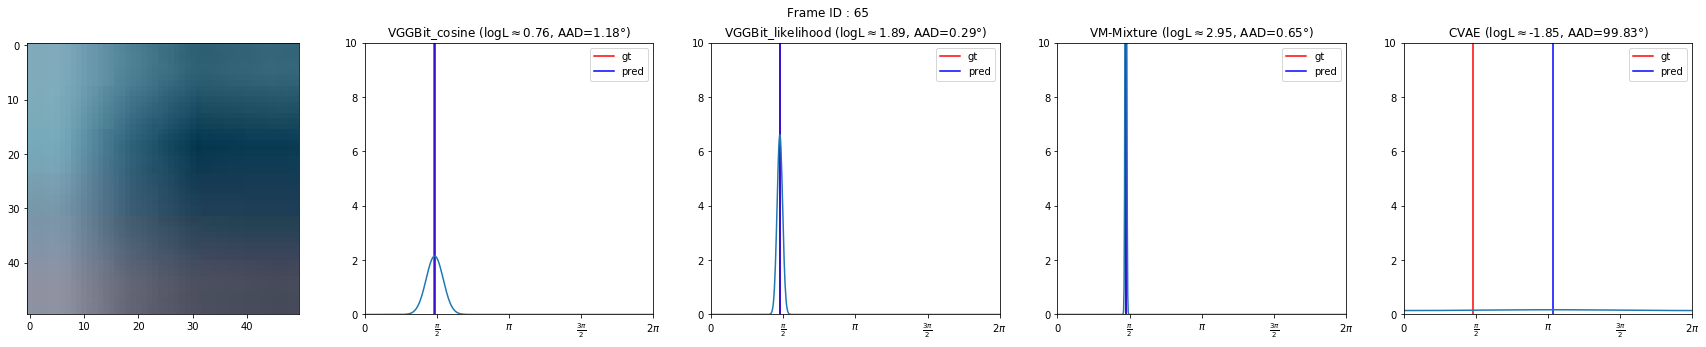

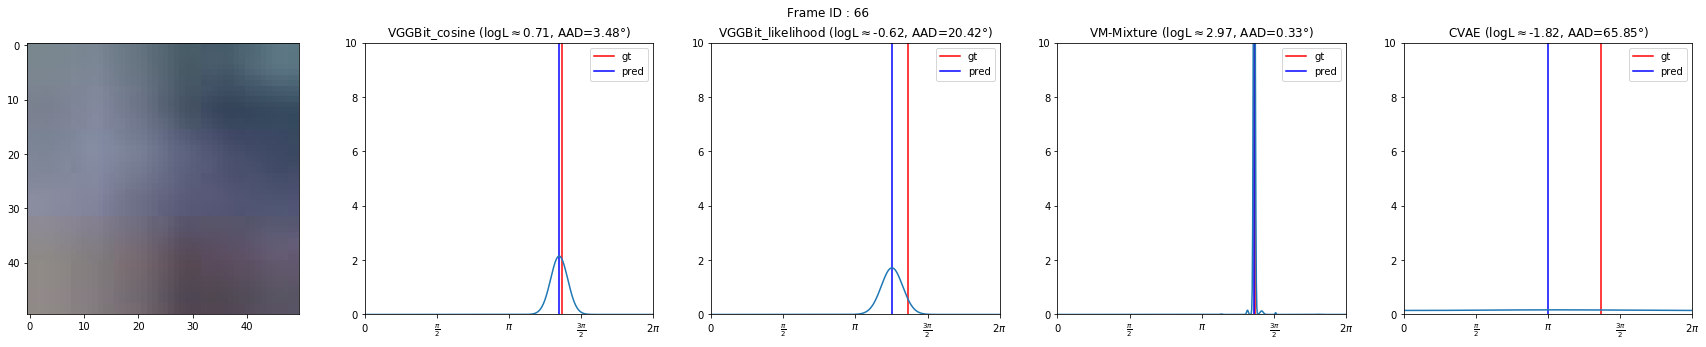

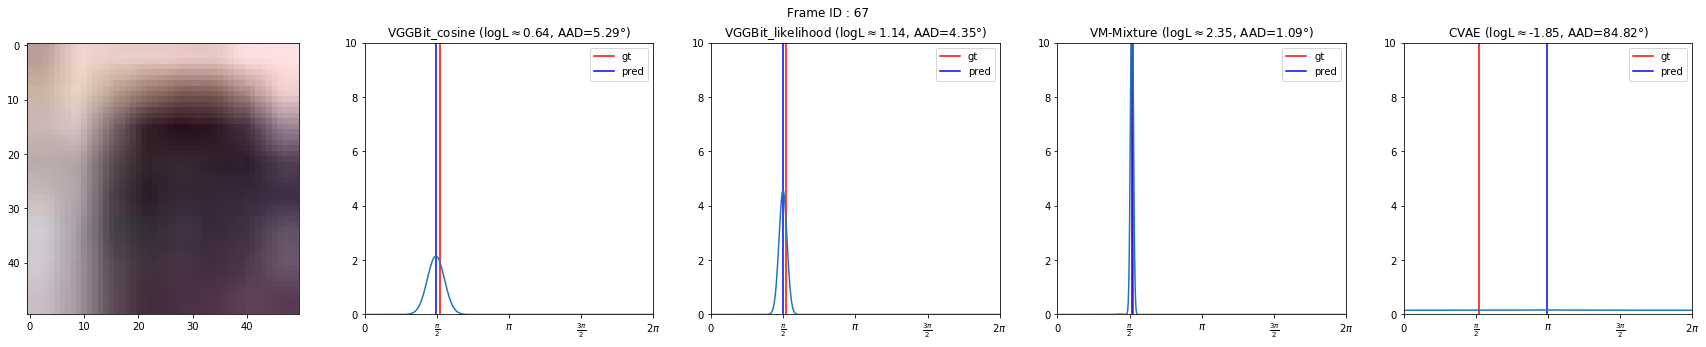

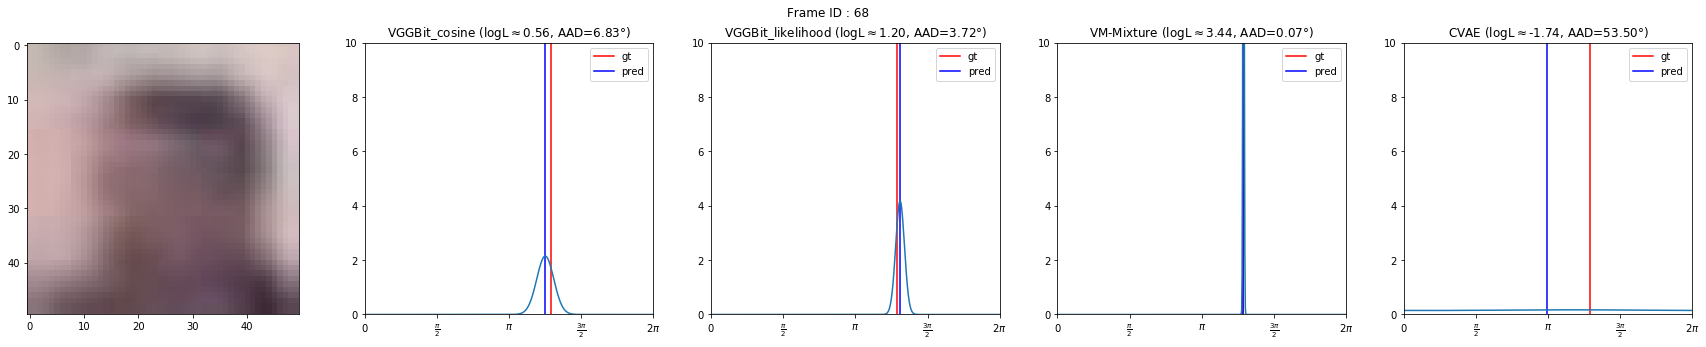

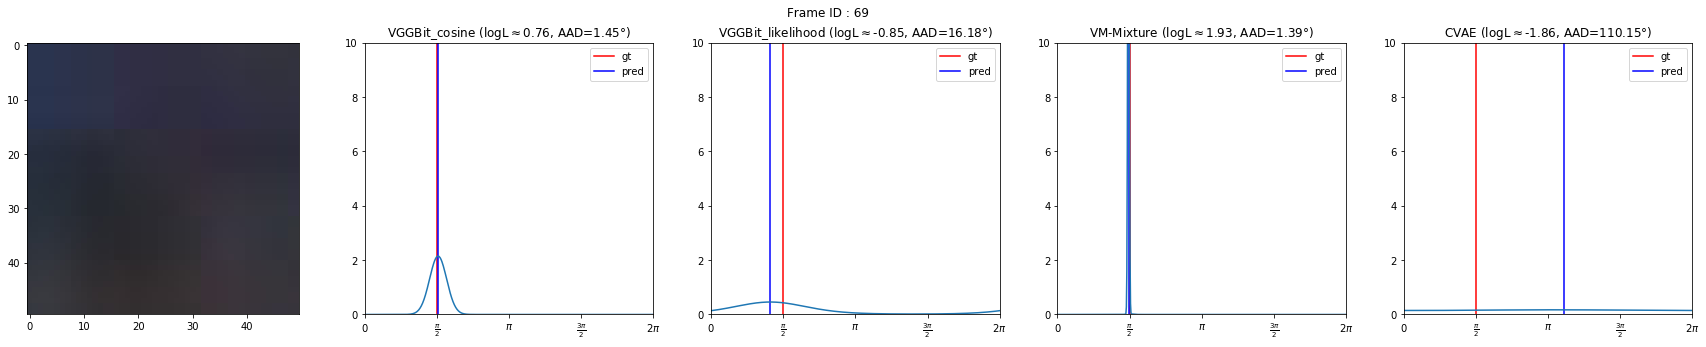

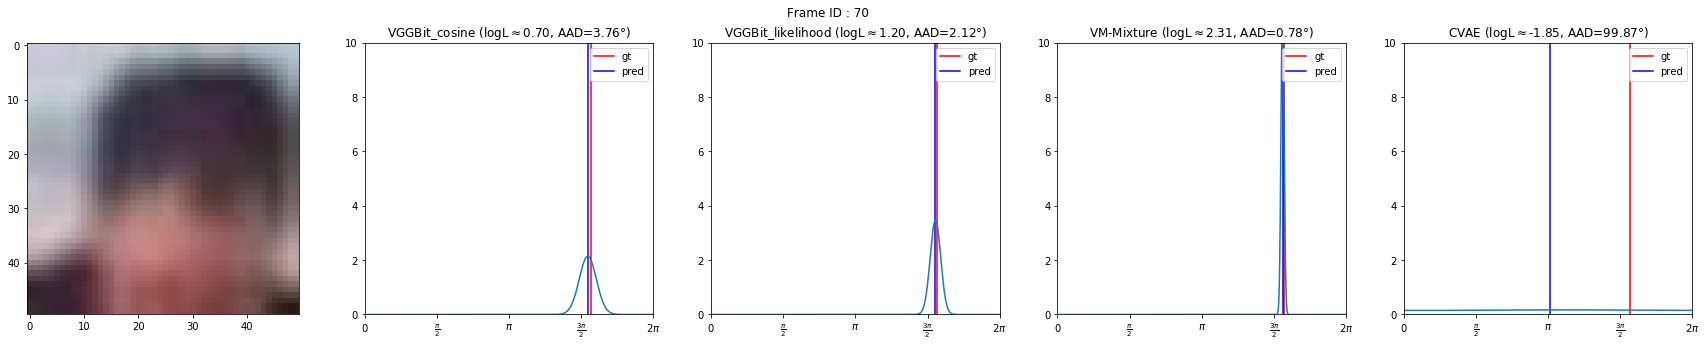

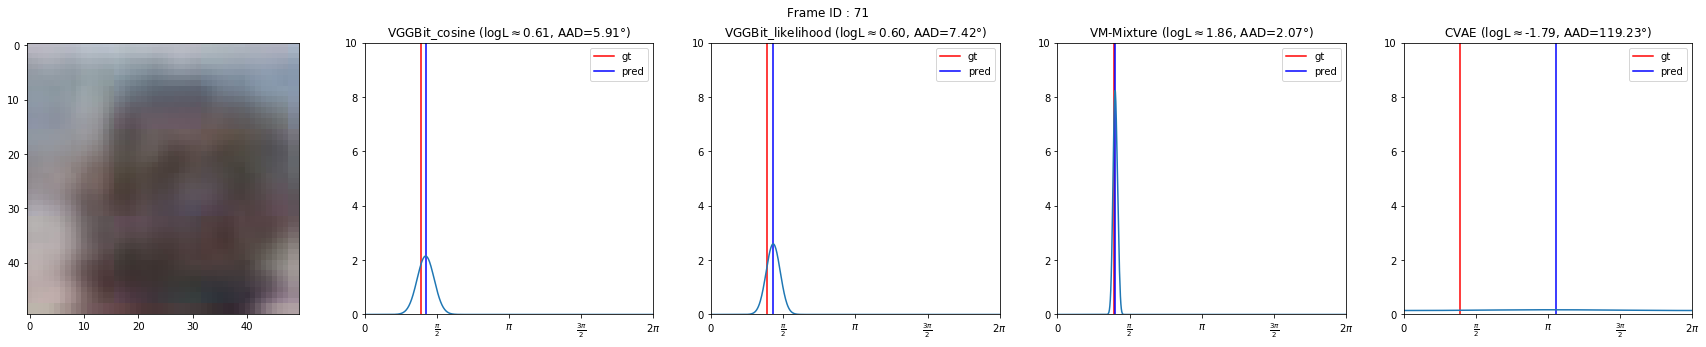

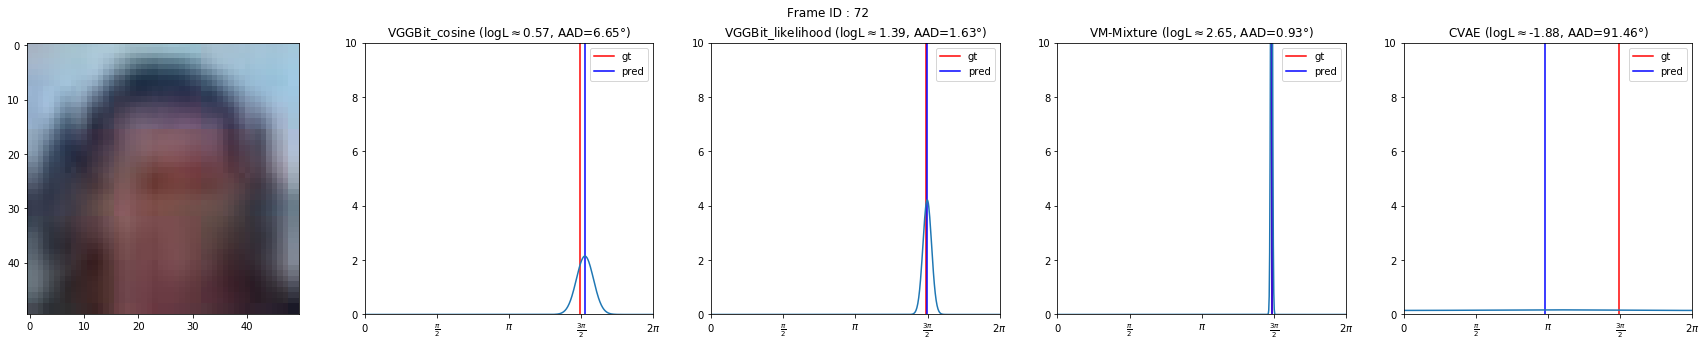

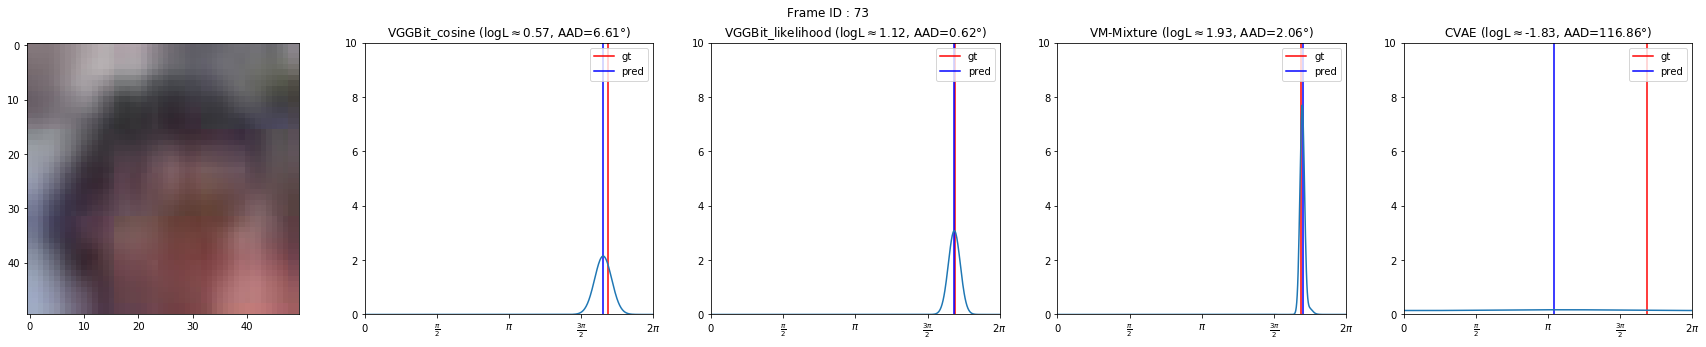

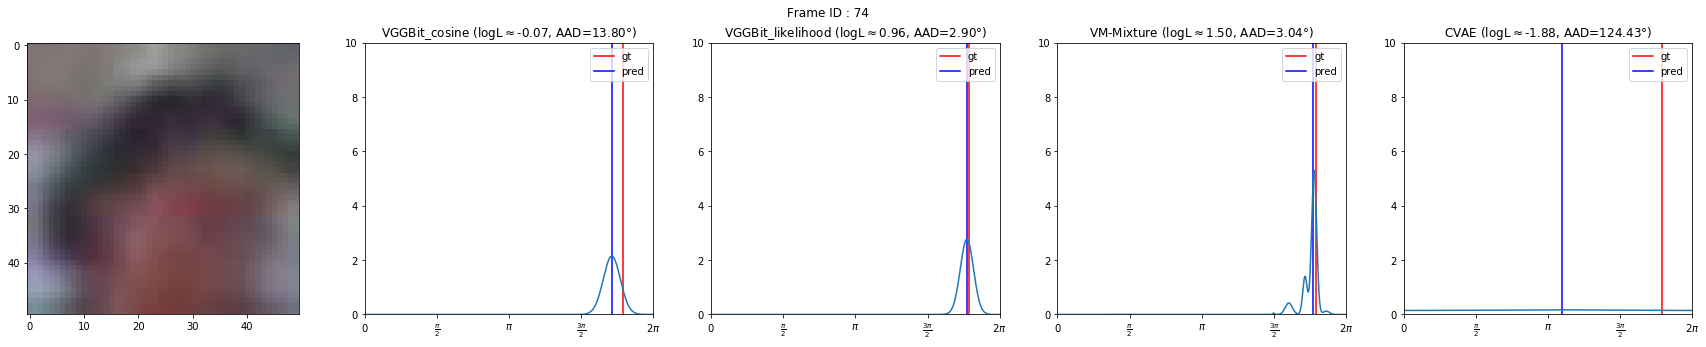

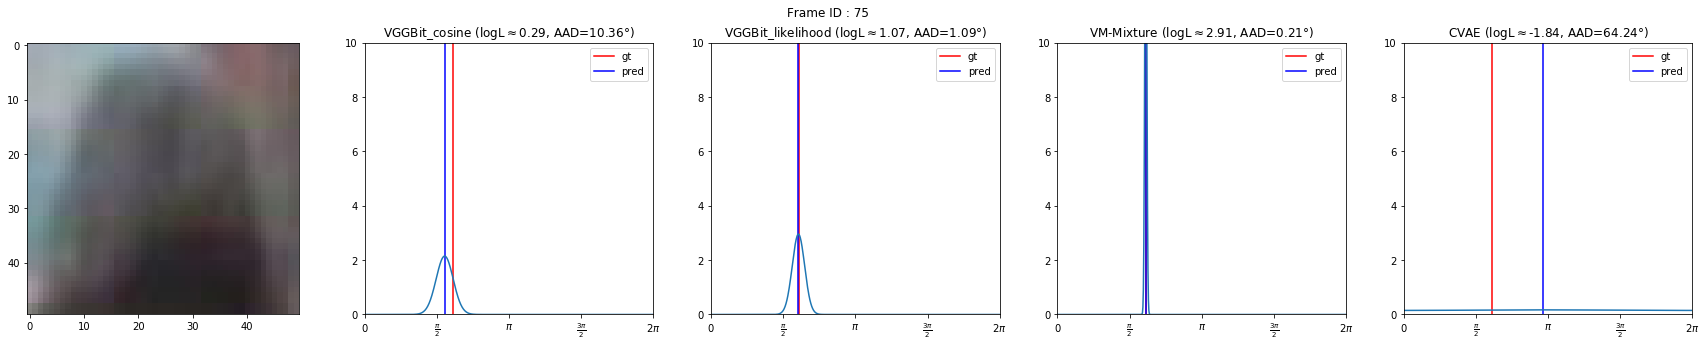

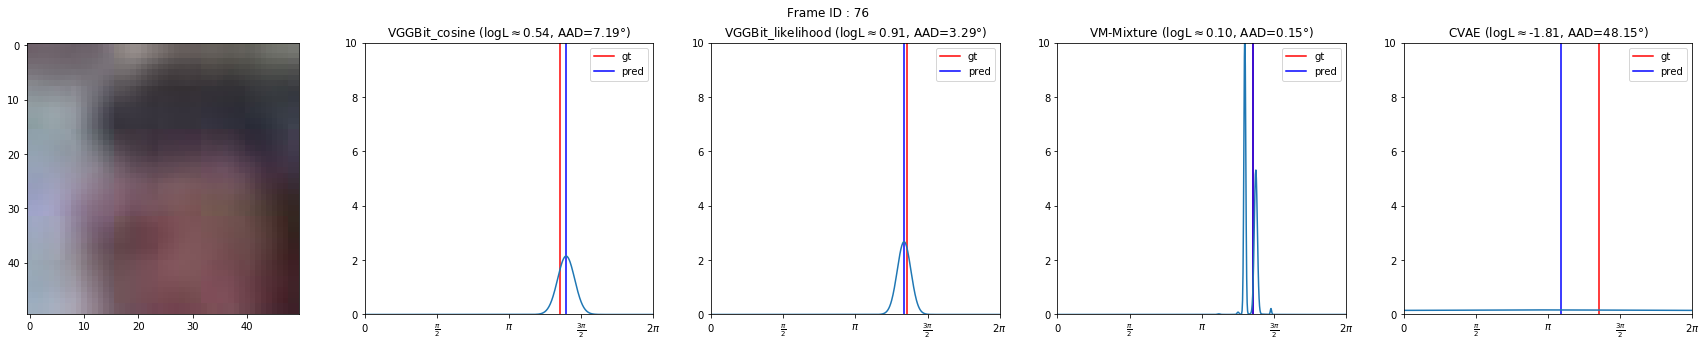

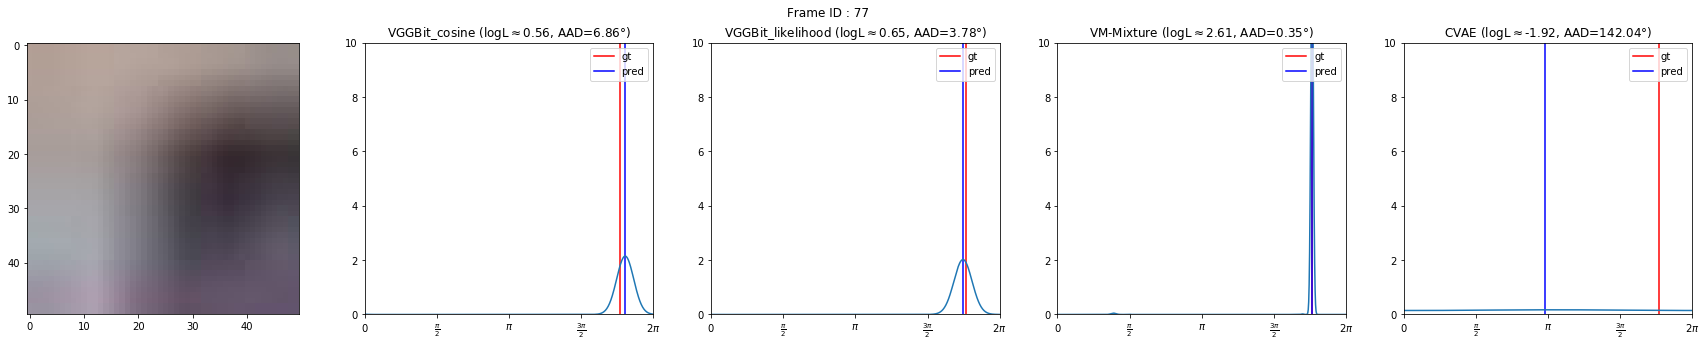

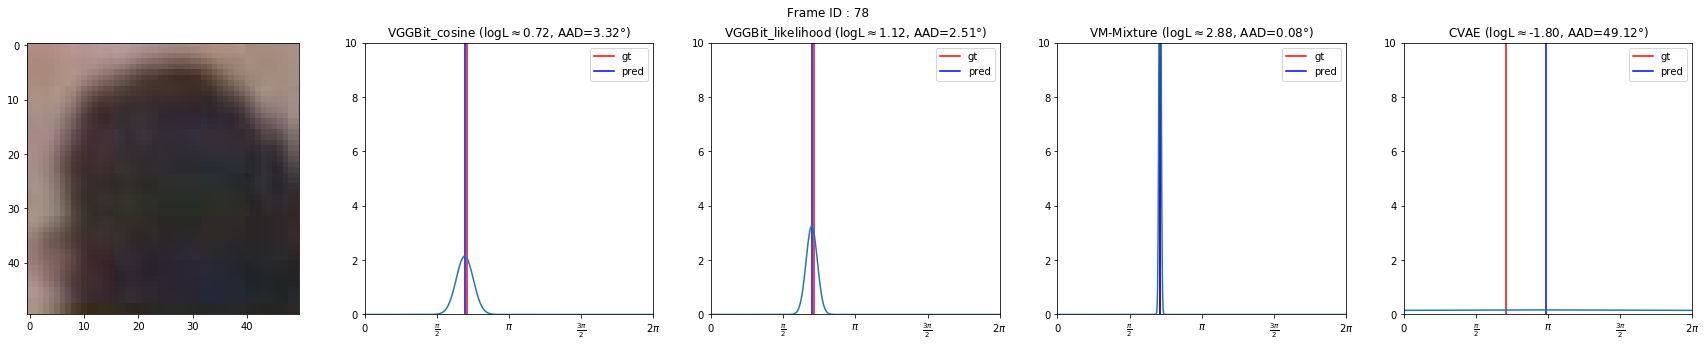

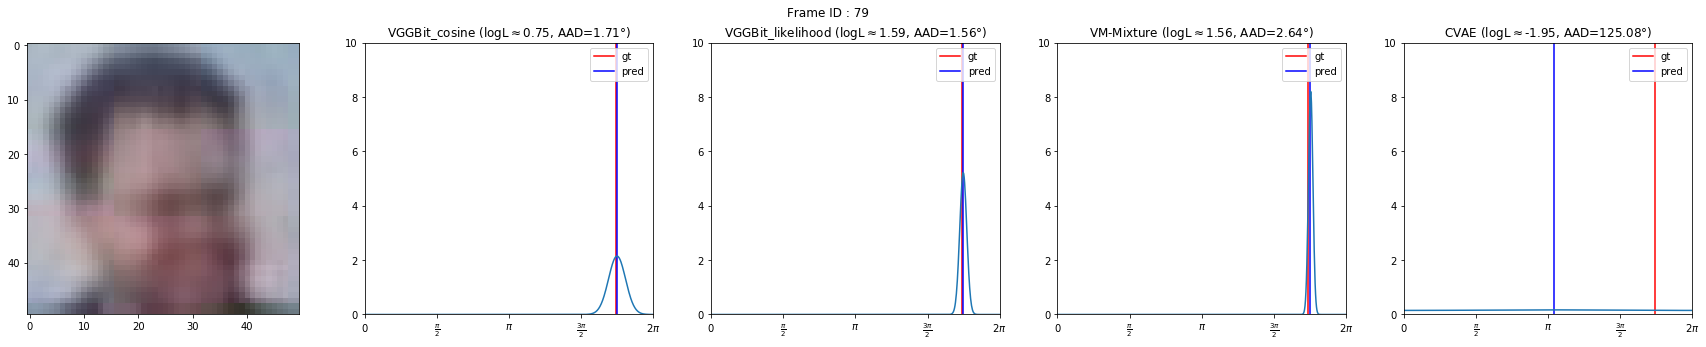

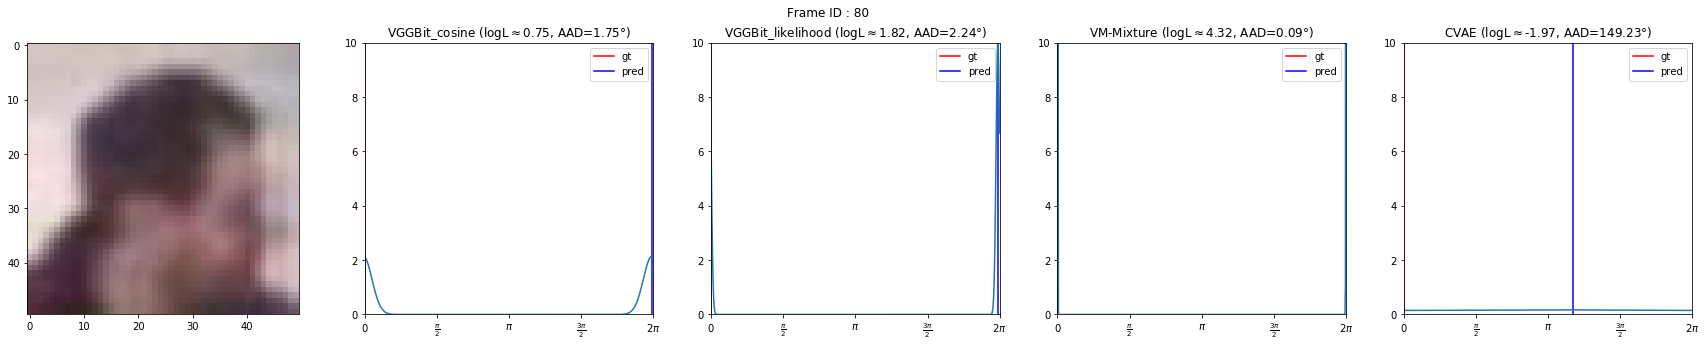

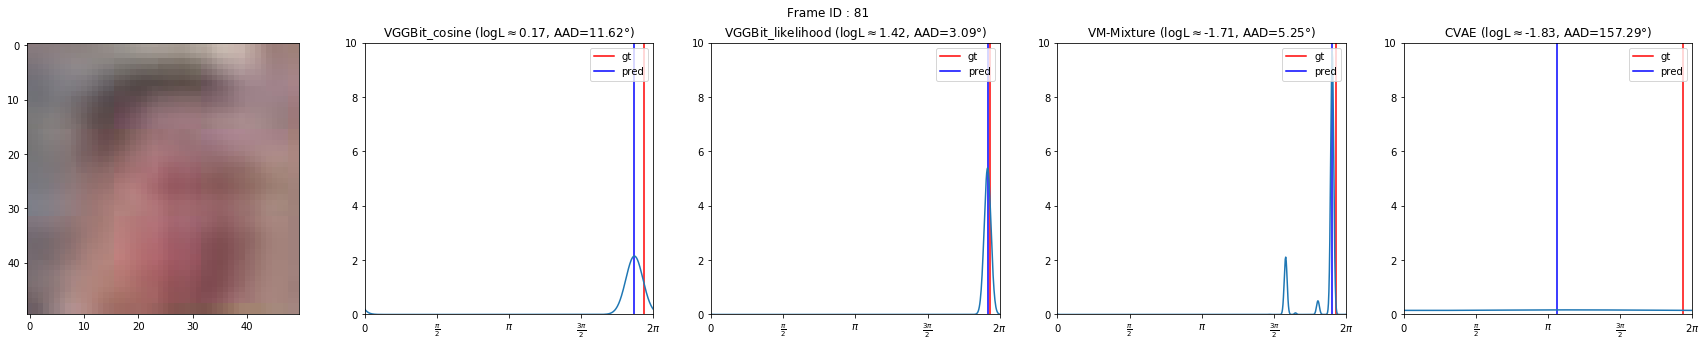

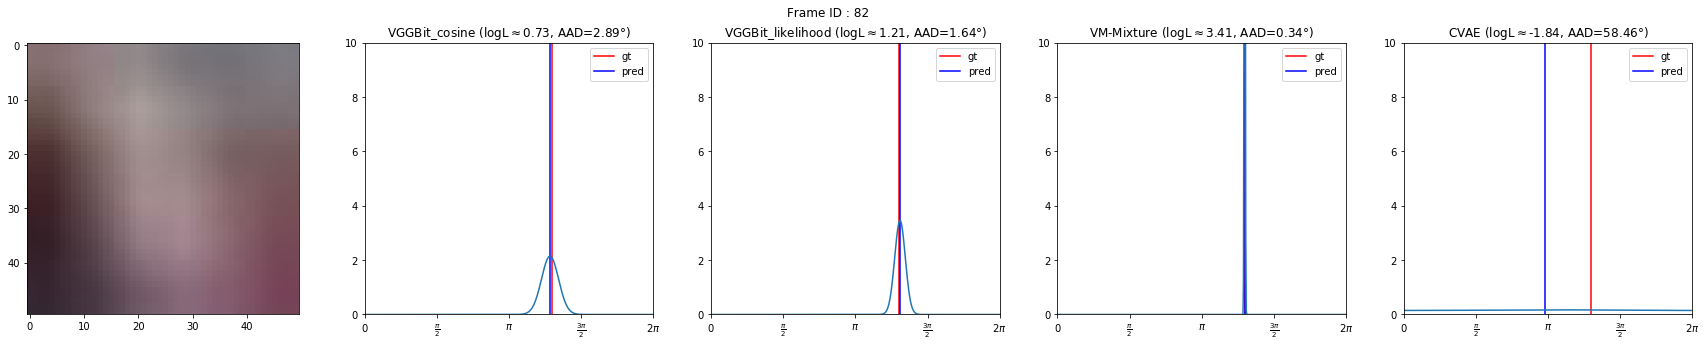

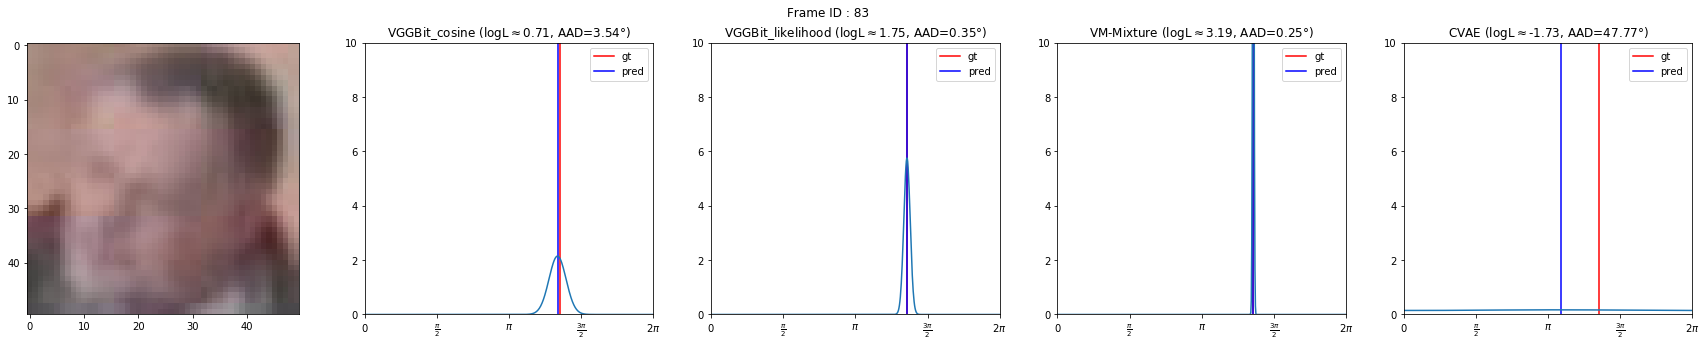

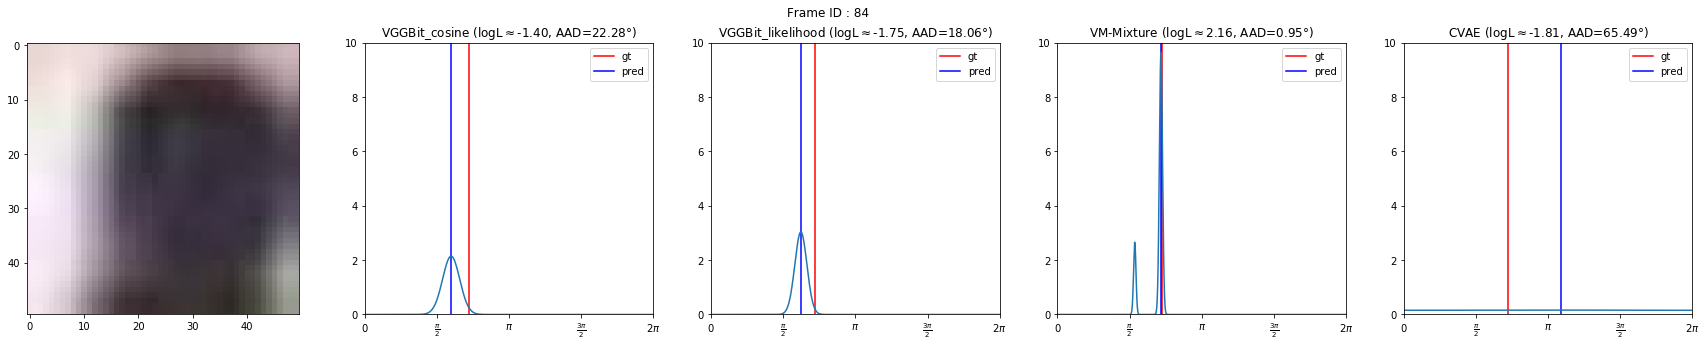

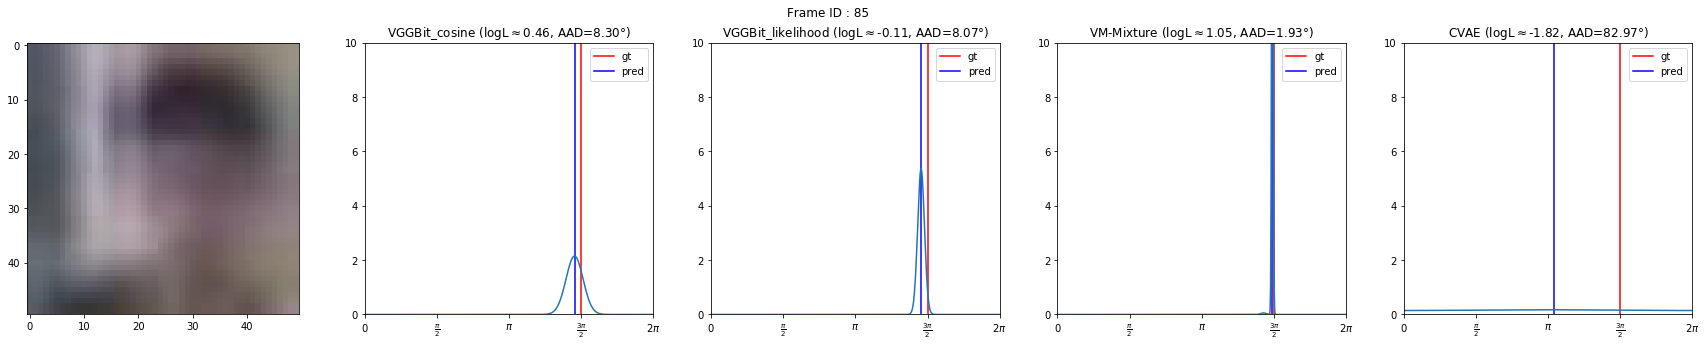

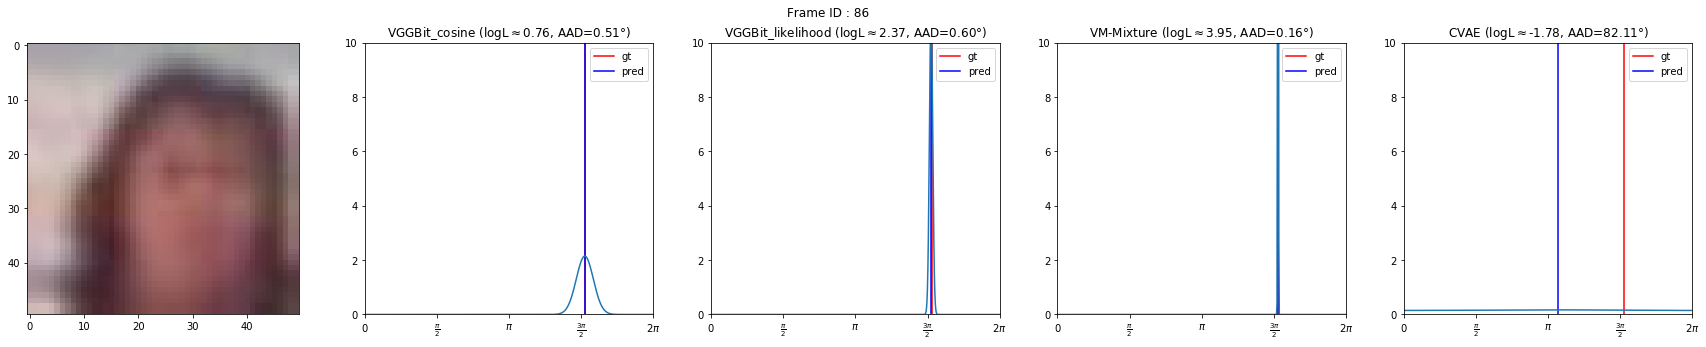

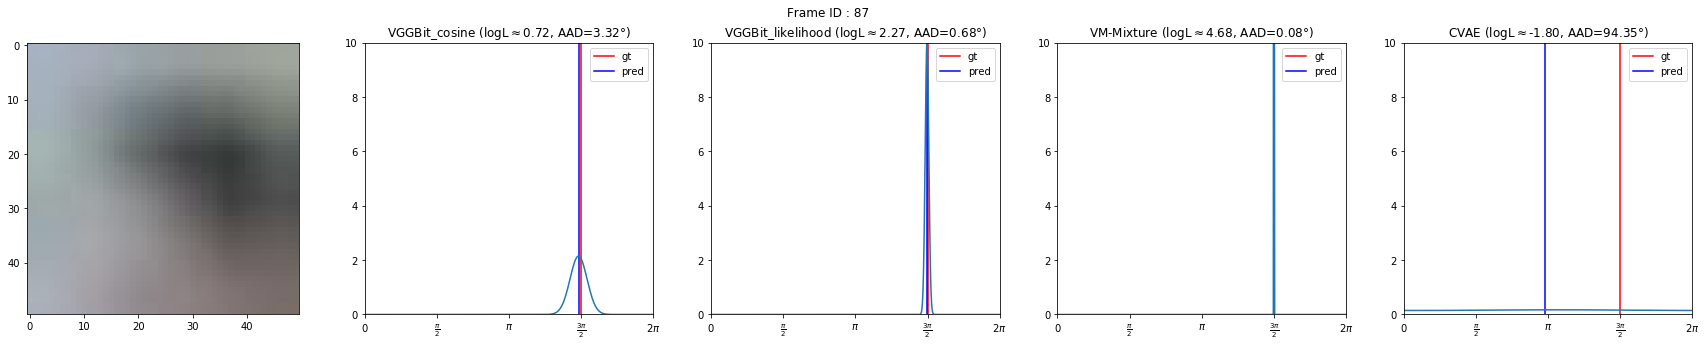

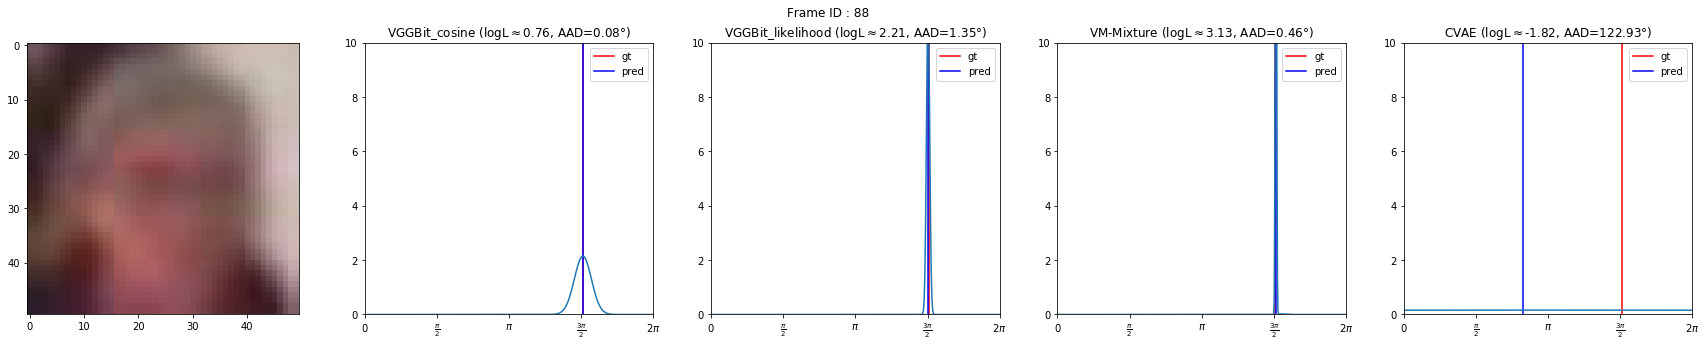

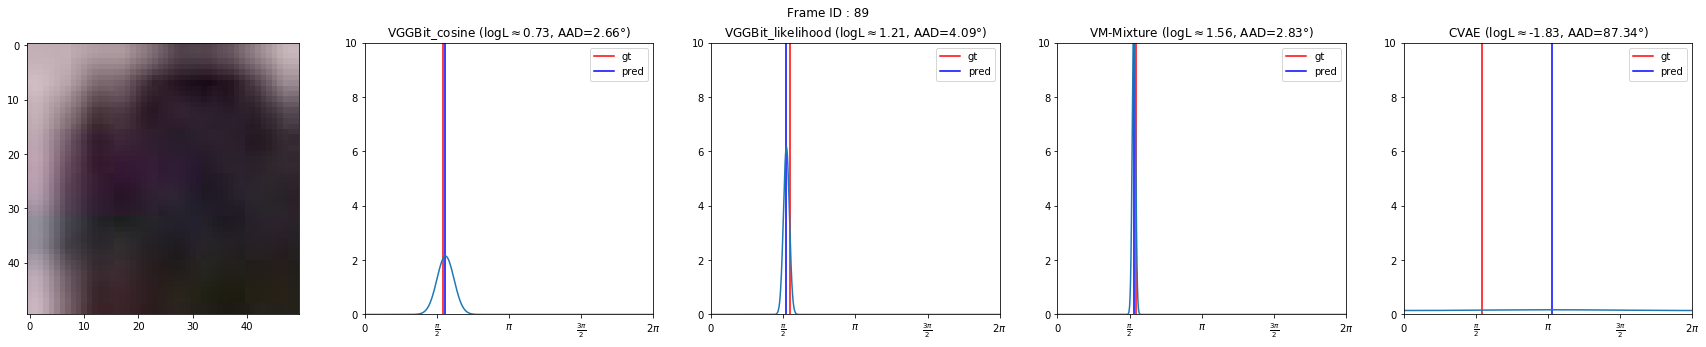

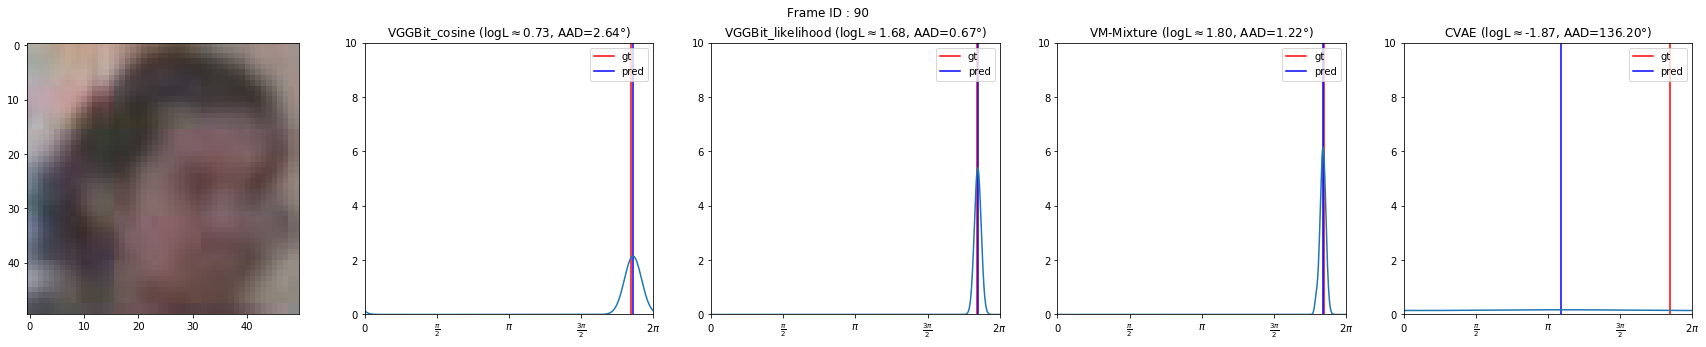

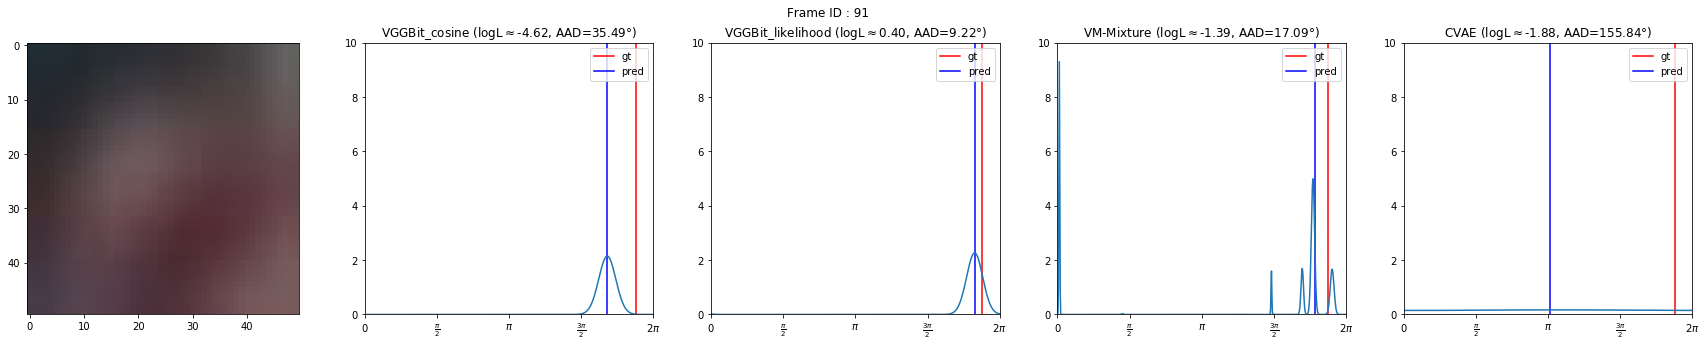

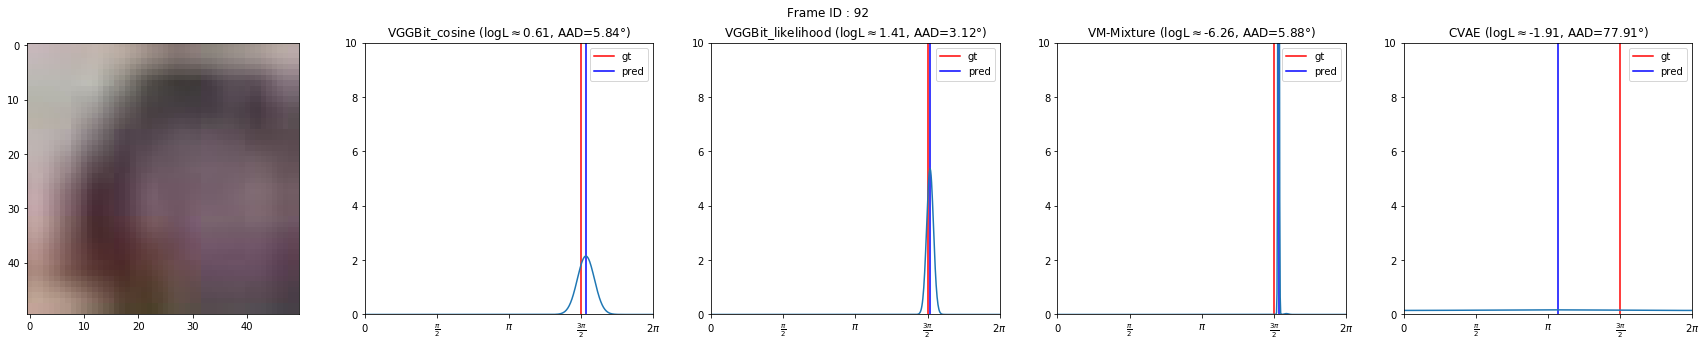

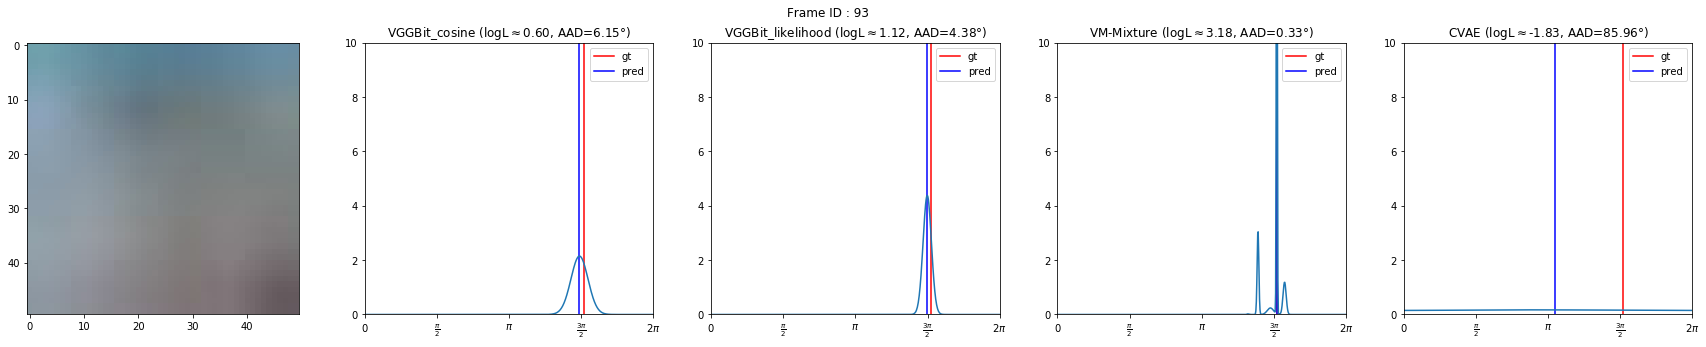

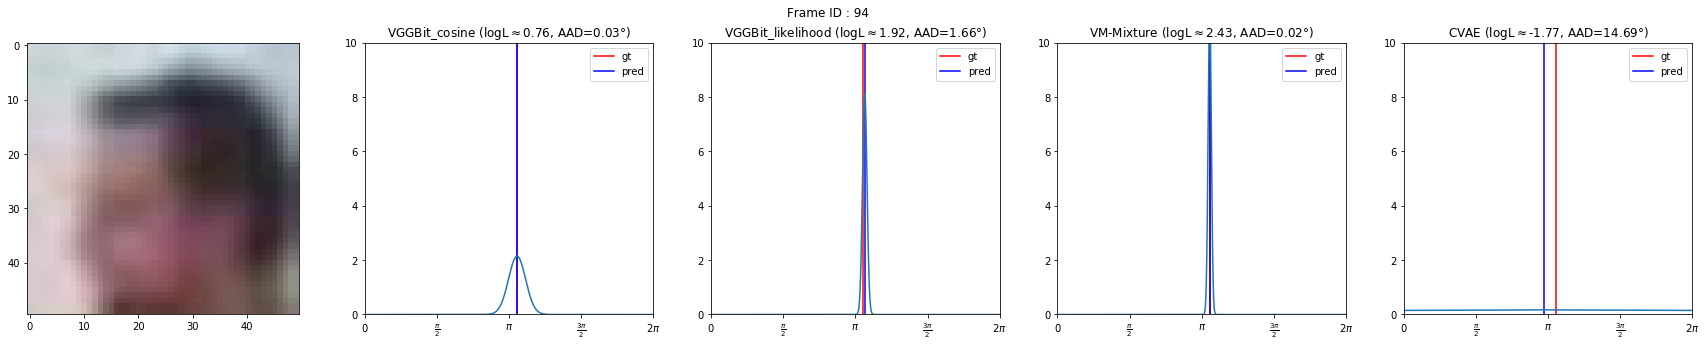

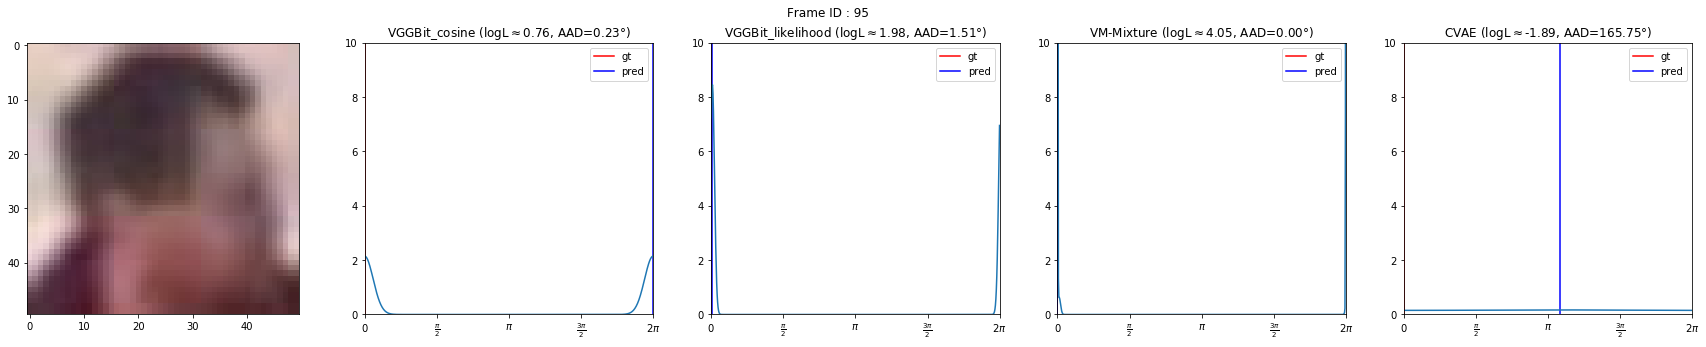

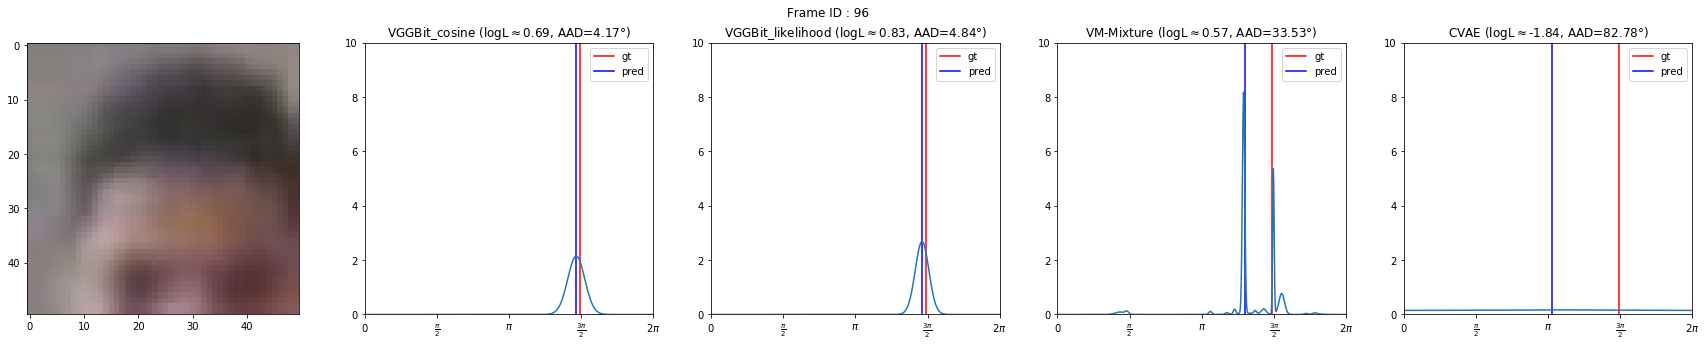

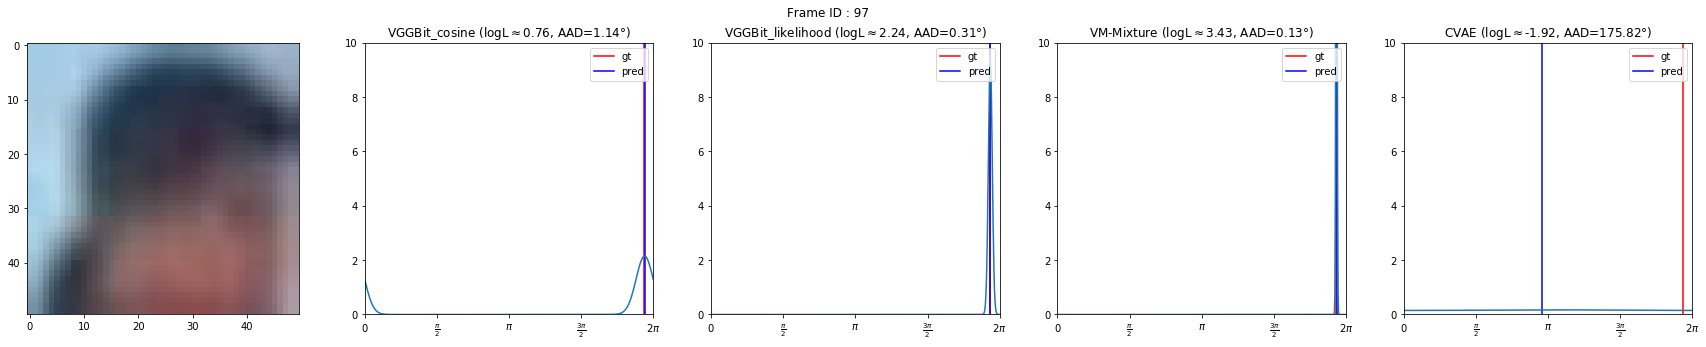

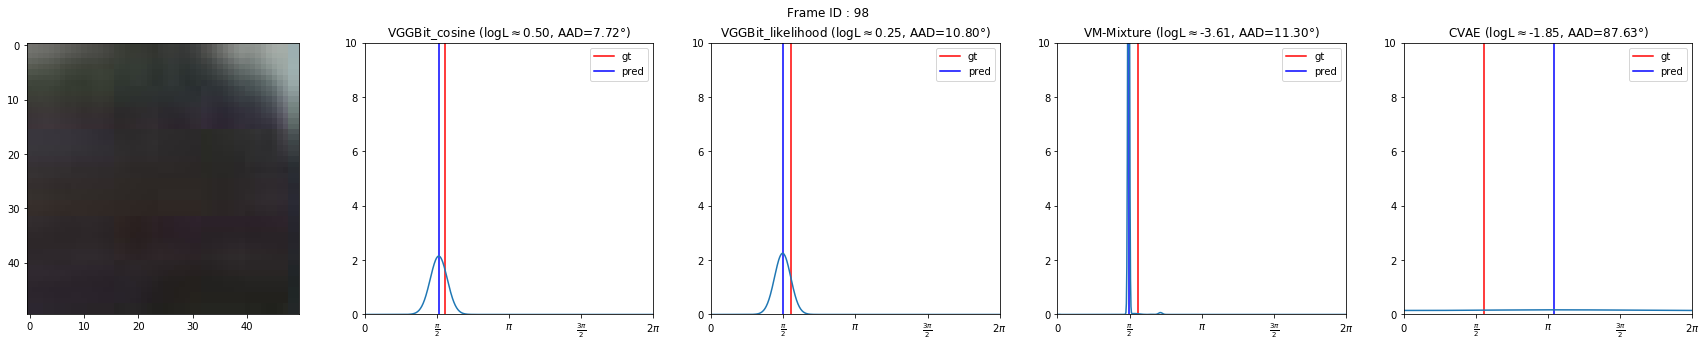

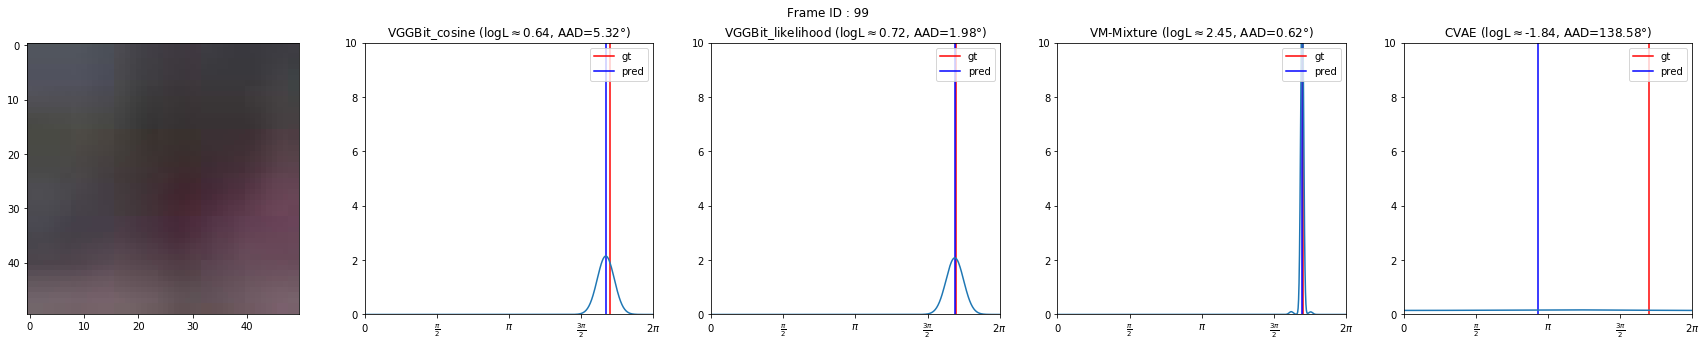

In [631]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fix, fid in enumerate(frames):
    
    pdfs_dict = {}
    likelihoods_dict = {}
    point_preds_dict = {}
    maad_dict = {}
    pdfs_dict['VGGBit_cosine'] = vggcosine_acc_pdf[fix]
    likelihoods_dict['VGGBit_cosine'] = results['cosine']['log_likelihood'][fix]
    maad_dict['VGGBit_cosine'] = results['cosine']['maad'][fix]
    point_preds_dict['VGGBit_cosine'] = results['cosine']['point_preds'][fix]
    pdfs_dict['VGGBit_likelihood'] = vgglikelihood_acc_pdf[fix]
    likelihoods_dict['VGGBit_likelihood'] = results['likelihood']['log_likelihood'][fix]
    maad_dict['VGGBit_likelihood'] = results['likelihood']['maad'][fix]
    point_preds_dict['VGGBit_likelihood'] = results['likelihood']['point_preds'][fix]
    pdfs_dict['VM-Mixture'] = vmmix_acc_pdf[fix]
    likelihoods_dict['VM-Mixture'] = results['mixture']['log_likelihood'][fix]
    maad_dict['VM-Mixture'] = results['mixture']['maad'][fix]
    point_preds_dict['VM-Mixture'] = results['mixture']['point_preds'][fix]
    pdfs_dict['CVAE'] = cvae_acc_pdfs[fix]
    likelihoods_dict['CVAE'] = results['cvae']['importance_log_likelihood'][fix]
    maad_dict['CVAE'] = results['cvae']['maad'][fix]
    point_preds_dict['CVAE'] = results['cvae']['point_preds'][fix]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], fid, xvals,  pdfs_dict, likelihoods_dict, maad_dict, point_preds_dict, yte_rad[fid])

/Users/sergey/BiternionNet/py_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


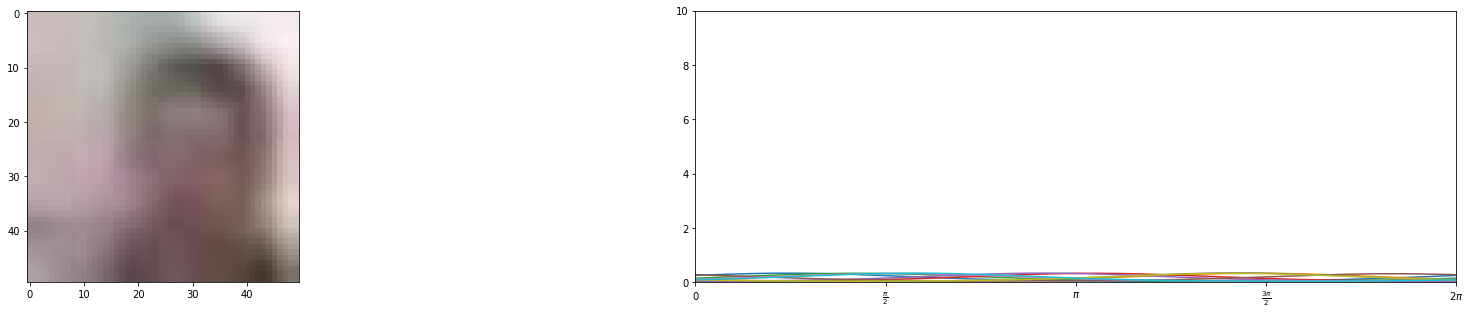

In [1002]:
fig, axs = plt.subplots(1, 2, figsize=(30, 5))

fid = 4

axs[0].imshow(xte[fid])

for sid in range(0, n_samples):
    plot_pdf(axs[1], xvals, cvae_samples_pdfs[fid, sid,:])

In [922]:
from utils.angles import deg2bit, bit2deg, bit2deg_multi, rad2bit

In [923]:
cvae_model.get_full_output(xte[0:1], yte_bit[0:1])

{'kappa_pred': array([[ 0.77763575]], dtype=float32),
 'log_sigma_encoder': array([[-0.01924161,  0.01980788, -0.00392363,  0.06789024,  0.03196023,
          0.04259288,  0.03081155,  0.02056622]], dtype=float32),
 'log_sigma_prior': array([[  2.95906048e-03,  -3.93125811e-06,   1.34207110e-03,
           1.67414604e-03,   1.53992360e-03,  -3.97563167e-03,
          -2.44171149e-03,  -2.02574825e-04]], dtype=float32),
 'mu_encoder': array([[-0.06056732, -0.12704241, -0.03171495, -0.03319639,  0.01502771,
          0.01742438, -0.01616769, -0.0157958 ]], dtype=float32),
 'mu_pred': array([[ 0.7146709 ,  0.69946086]], dtype=float32),
 'mu_prior': array([[-0.00460858, -0.00291566, -0.00117998, -0.00039406,  0.00304649,
          0.0030626 , -0.00318174,  0.00249462]], dtype=float32),
 'u_encoder_samples': array([[ 2.1776762 , -0.3802653 , -1.83829367,  0.25638384, -0.94099081,
         -0.4709911 ,  0.53460115, -0.75003326]], dtype=float32)}

In [924]:
cvae_model.get_full_output(xte[0:1], yte_bit[0:1])

{'kappa_pred': array([[ 1.24784982]], dtype=float32),
 'log_sigma_encoder': array([[-0.01924161,  0.01980788, -0.00392363,  0.06789024,  0.03196023,
          0.04259288,  0.03081155,  0.02056622]], dtype=float32),
 'log_sigma_prior': array([[  2.95906048e-03,  -3.93125811e-06,   1.34207110e-03,
           1.67414604e-03,   1.53992360e-03,  -3.97563167e-03,
          -2.44171149e-03,  -2.02574825e-04]], dtype=float32),
 'mu_encoder': array([[-0.06056732, -0.12704241, -0.03171495, -0.03319639,  0.01502771,
          0.01742438, -0.01616769, -0.0157958 ]], dtype=float32),
 'mu_pred': array([[ 0.93057203,  0.36610898]], dtype=float32),
 'mu_prior': array([[-0.00460858, -0.00291566, -0.00117998, -0.00039406,  0.00304649,
          0.0030626 , -0.00318174,  0.00249462]], dtype=float32),
 'u_encoder_samples': array([[-1.2009356 , -0.47168112,  1.9669503 , -0.81748736, -1.42440534,
         -1.02796042,  1.52888334, -0.16031907]], dtype=float32)}

In [782]:
bit2deg(cvae_model.decoder_model.predict(xte[0:1]))

array([ 80.90246582], dtype=float32)

In [683]:
bit2deg(cvae_model.decoder_model.predict(xte[1:2]))

array([ 188.53445435], dtype=float32)

In [975]:
cvae_model.decoder_model.predict(xte[1:2])[:,2]

array([ 1.04503703], dtype=float32)

In [493]:
a 

array([[-0.87069392,  0.49182525,  0.03346517],
       [-0.95399839,  0.29981199,  0.02377366],
       [-0.97068828, -0.24034184,  0.09753948],
       [-0.96711349, -0.254345  ,  0.12577194],
       [-0.85348547, -0.52111661,  0.00814516],
       [-0.98808008,  0.15394041,  0.16612144],
       [-0.97540039, -0.22044079,  0.0246888 ],
       [-0.99293119,  0.11869084,  0.04382694],
       [-0.99581105,  0.09143533,  0.07932875],
       [-0.99880785,  0.04881484,  0.16643648],
       [-0.79102778, -0.61178017,  0.12167247],
       [-0.83950877,  0.54334611,  0.05823144],
       [-0.83844793,  0.54498178,  0.08772651],
       [-0.89610052, -0.44385111,  0.0375961 ],
       [-0.99580991, -0.09144686,  0.00827602],
       [-0.99434066, -0.10623911,  0.04200861],
       [-0.73770672, -0.67512107,  0.05050937],
       [-0.9722386 ,  0.23399161,  0.06044078],
       [-0.96634471, -0.25725076,  0.07392774],
       [-0.96134484,  0.27534711,  0.01369867],
       [-0.99990451,  0.01382236,  0.020

In [309]:
results['likelihood']['log_likelihood'].shape

(100, 1)

In [297]:
def eval_all_models(x, y_deg, data_part):
    
    results = {}
    
    print("*****EVALUATING ON %s*****"%data_part)
    print("evaluating VGGBit (cosine loss)..")
    results['cosine'] = vggbit_cosine_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VGGBit (likelihood loss)..")
    results['likelihood'] = vggbit_likelihood_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VM-Mixture..")
    results['mixture'] = vmmix_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating CVAE..")
    results['cvae'] = cvae_model.evaluate(x, y_deg, data_part, return_per_image=True)
    
    return results